En esta EDA, intentaremos ver las diferentes variables disponibles, su reparticion, sus relaciones con el nivel de salario pero tambien con otras variables que representan la identidad de los preguntados y tambien sus datos financieros.

# Librairies

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency,kendalltau,f_oneway,kruskal
import numpy as np
from scipy.stats import zscore, f_oneway
from scipy.stats import ttest_ind
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Dataset

Tenemos 15 variables :

- Age : edad 
- Workclass : el tipo de empleador
- fnlwgt : que mostra la representatividad del individuo
- Education : el nivel mas alto de educacion
- Education-Num : una representacion numerica de la educacion
- Marital status : estado civil
- Occupation : el tipo de trabajo
- Relationship : relacion familiar en el hogar
- Race : grupo étnico
- Sex : sexo biologico
- Capital Gain : ganancias monetarias en los ultimos 12 meses
- Capital Loss : perdidas monetaria en los ultimos 12 meses
- Hours per week : Numero de horas trabajadas por semana
- Country : pais de origen
- Income : nivel de ingreso anual (que sera nuestra target)

In [148]:
ruta=r"..\Data\income_data.csv"
df_raw=pd.read_csv(ruta,sep=",")
df_raw.shape

(48842, 15)

In [149]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [150]:
df_raw.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [151]:
df_raw.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

No tenemos nulos pero tenemos valores extranas como "?" en la variable workclass y ocupation por ejemplo

In [152]:
df_raw.duplicated().sum()

np.int64(52)

Tenemos duplicados que vamos a eliminar.

In [153]:
df_raw = df_raw.drop_duplicates()
df_raw.duplicated().sum()

np.int64(0)

In [154]:
num_cols = list(df_raw.select_dtypes(include=['float64', 'int64']).columns)
cat_cols = list(df_raw.select_dtypes(include=['object']).columns)

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


# ANALISI UNIVARIANTE

In [155]:
for col in df_raw.columns:
    value_counts = df_raw[col].value_counts().head(50)
    percentage = round(value_counts/df_raw.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valeur': value_counts.index, 'Nombre': value_counts.values, 'Pourcentage': percentage.values}))
    print(f"Type {df_raw[col].dtype}")
    print("-----------------------------")

age
    Valeur  Nombre  Pourcentage
0       36    1348         2.76
1       35    1336         2.74
2       33    1335         2.74
3       23    1325         2.72
4       31    1324         2.71
5       34    1303         2.67
6       37    1279         2.62
7       28    1279         2.62
8       30    1275         2.61
9       38    1263         2.59
10      32    1253         2.57
11      41    1234         2.53
12      27    1231         2.52
13      29    1221         2.50
14      24    1205         2.47
15      39    1204         2.47
16      25    1190         2.44
17      40    1187         2.43
18      22    1176         2.41
19      42    1164         2.39
20      26    1153         2.36
21      20    1111         2.28
22      43    1103         2.26
23      46    1095         2.24
24      45    1095         2.24
25      21    1092         2.24
26      47    1080         2.21
27      44    1066         2.18
28      19    1045         2.14
29      51     877         1.80
30  

- En general, tenemos un dataset desbalanceado sobre nuestro objetivo Income.
- Quizas tenemos sesgo de genero porque tenemos mas hombres que mujeres. 
- Tenemos tambien una mayoria de 86% de personas blancas.
- Tenemos "?" in workclass, occupation, native-country
- Race tiene "other" (0,8%). El "other-services" y "other relatives" (que representant 10% para el ultimo) en occupation y relationship me molestan porque no es preciso.
- Tenemos tambien persona que jamas han trabajado y sin salario (0,06% total)
- Parece que para Capital Gain no se puede escribir mas de 99 999 euros.
- En native country, si hubo un espacio solo se tomo en consideracion la premer palabra asi tenomos problemas sobre Hong Kong y South Africa.

## QUANTITATITVA

In [156]:
df_raw[num_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
age,48790.000000,38.652798,13.708493,17.000000,28.000000,37.000000,48.000000,58.000000,63.000000,74.000000,90.000000
fnlwgt,48790.000000,189668.999365,105617.231232,12285.000000,117555.000000,178138.500000,237606.250000,328466.000000,379522.000000,509514.190000,1490400.000000
educational-num,48790.000000,10.078807,2.570046,1.000000,9.000000,10.000000,12.000000,13.000000,14.000000,16.000000,16.000000
capital-gain,48790.000000,1080.217688,7455.905921,0.000000,0.000000,0.000000,0.000000,0.000000,5013.000000,15024.000000,99999.000000
capital-loss,48790.000000,87.595573,403.209129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2001.000000,4356.000000
hours-per-week,48790.000000,40.425886,12.392729,1.000000,40.000000,40.000000,45.000000,55.000000,60.000000,80.000000,99.000000


In [157]:
df_raw[num_cols].skew().sort_values(ascending=False)

capital-gain       11.888265
capital-loss        4.567037
fnlwgt              1.439698
age                 0.556582
hours-per-week      0.239652
educational-num    -0.314229
dtype: float64

In [158]:
df_raw[num_cols].kurt().sort_values(ascending=False)

capital-gain       152.526968
capital-loss        19.987928
fnlwgt               6.061237
hours-per-week       2.950820
educational-num      0.621267
age                 -0.186851
dtype: float64

Tenemos distribuciones normales exepto Capital_gain y capital_loss pero este es normal porque podemos tener muchas diferencias dependiendo de la apetencia de la gente a invertir.

In [159]:
df_raw["income"][df_raw["age"]>65].value_counts().sort_index(ascending=False)

income
>50K      357
<=50K    1445
Name: count, dtype: int64

Tenemos mucha gente mayor que 65 anos que quizas se han retirado o que pueden haber seguido trabajado si son emprendedores. Con busquedas se puede ver que 65 anos es normalemnte la norma para jubilarse.

In [160]:
# Una semana intensiva con 6 dias de 10 horas
df_raw["income"][df_raw["hours-per-week"]>60].value_counts().sort_index(ascending=False)

income
>50K      599
<=50K    1077
Name: count, dtype: int64

In [161]:
df_raw["income"][df_raw["hours-per-week"]>80].value_counts().sort_index(ascending=False)

income
>50K     100
<=50K    218
Name: count, dtype: int64

In [162]:
df_raw["hours-per-week"].median()

40.0

Misma cosa con el nombre de horas trabajadas. En los estados unidos, parece que se puede trabajar mucho y que no es como en europa. Ademas, pueden ser emprendedores que no cuentan las horas trabajadas. Lo media y la mediana es 40 horas.

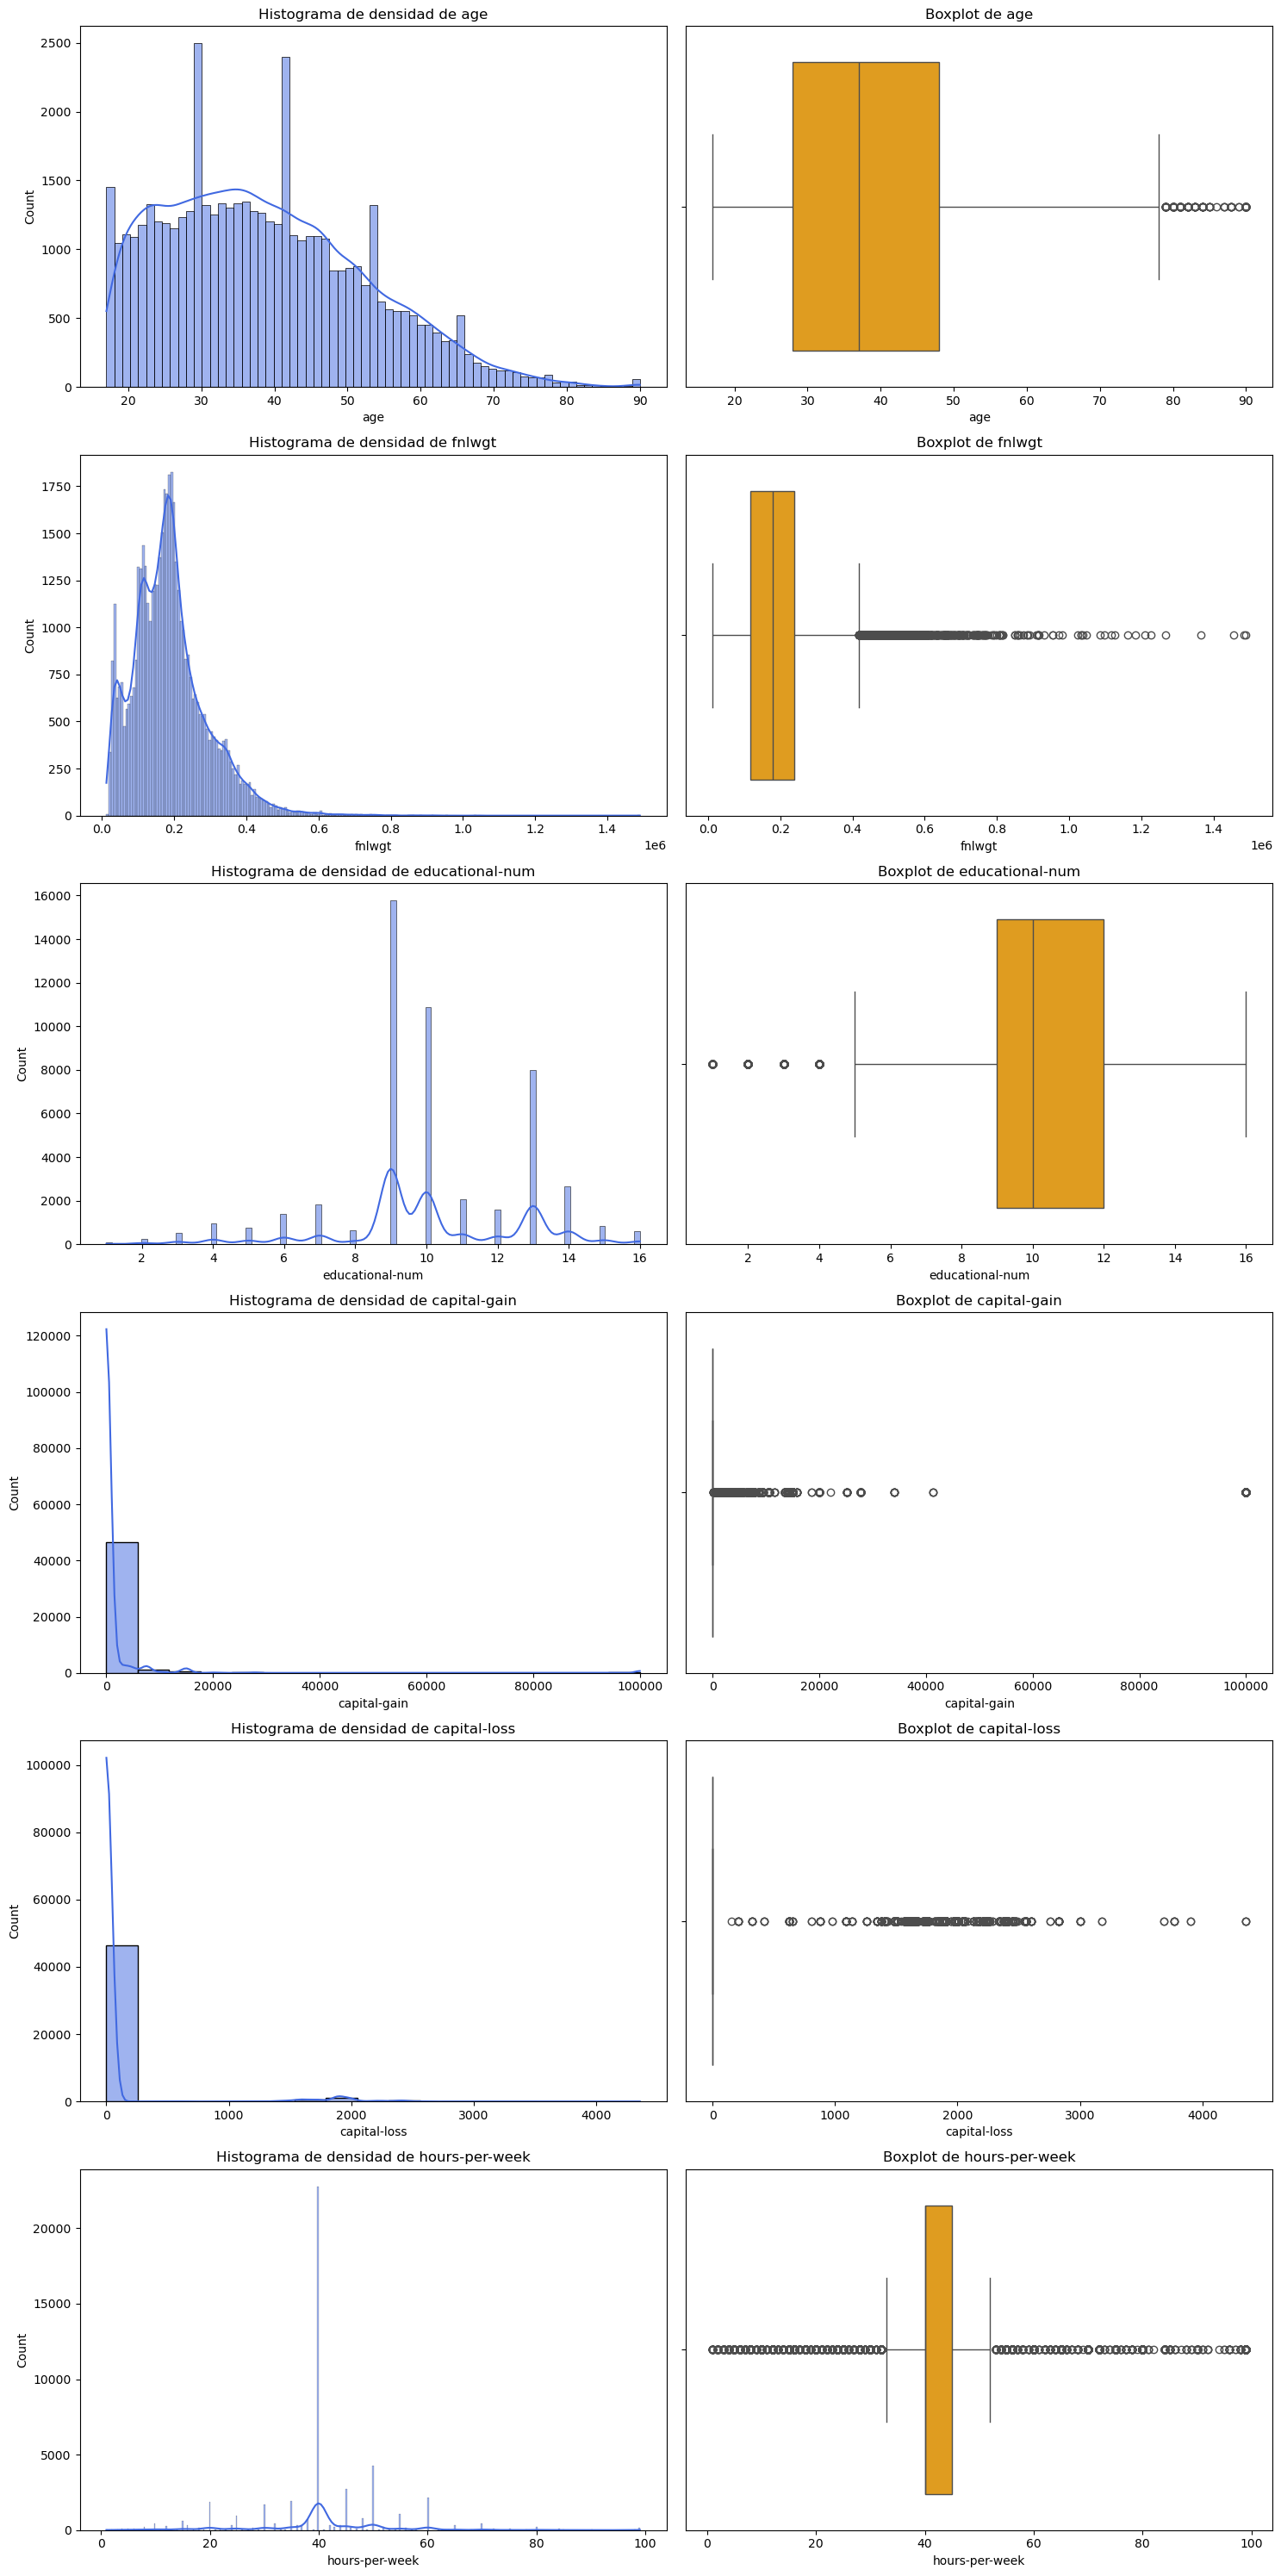

In [163]:
fig, axes = plt.subplots(nrows=len(df_raw[num_cols].columns), ncols=2, figsize=(15, 5 * len(df_raw[num_cols].columns)))

for i, column in enumerate(df_raw[num_cols]):
   
    sns.histplot(df_raw[column], kde=True, ax=axes[i, 0], color='royalblue')
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    
    sns.boxplot(x=df_raw[column], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot de {column}')



plt.tight_layout()
plt.show()

Tenemos outliers especialmente para capital gain y capital loss. Podemos anadir tambien que  hay muchas gente con un capital-loss cerca de 2000 y tambien que tenemos un numero importante de gente con capital-gain entre 1 y 20 000 Para la edad hemos visto que es muy particular porque no hay un maximo de edad para trabajar. Y para Hours-per-week, la mayoria trabajan 40 horas. La variable fnlwgt no sirve como variable tal cual pero podra servir luego para ajustar los pesos de los registros para dar mas reprensentatividad.

## CUALITATIVA

In [164]:
df_raw[cat_cols].describe().T

,count,unique,top,freq
workclass,48790,9,Private,33860
education,48790,16,HS-grad,15770
marital-status,48790,7,Married-civ-spouse,22366
occupation,48790,15,Prof-specialty,6165
relationship,48790,6,Husband,19703
race,48790,5,White,41714
gender,48790,2,Male,32614
native-country,48790,42,United-States,43792
income,48790,2,<=50K,37109


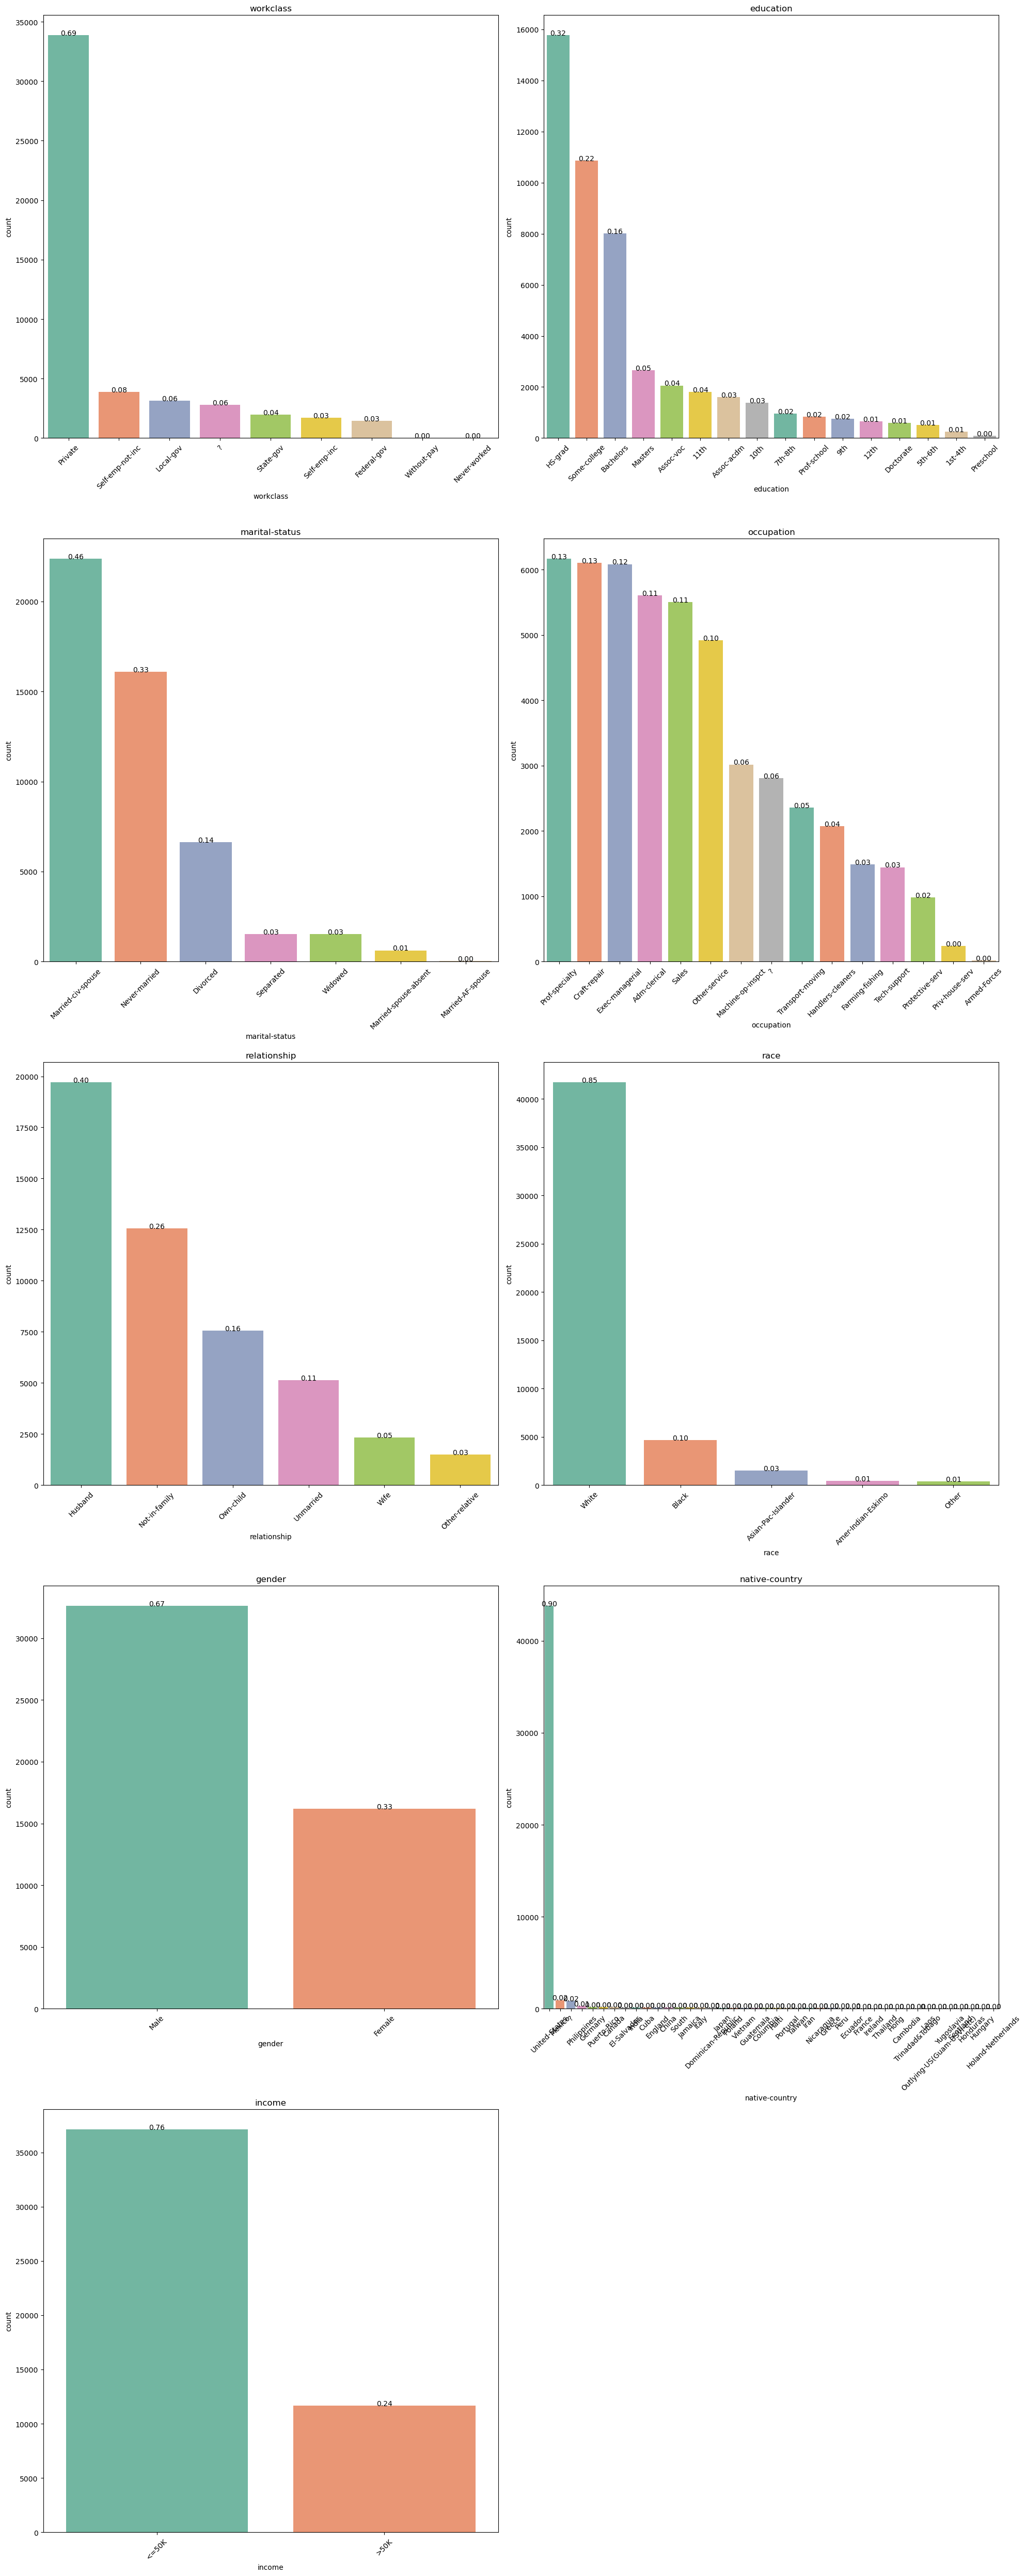

In [165]:

plt.figure(figsize=(20, 50))

n = len(cat_cols)
n_cols = 2
n_rows = math.ceil(n / n_cols)

for i, var in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    order = df_raw[var].value_counts().sort_values(ascending=False).index
    ax = sns.countplot(data=df_raw, x=var, palette="Set2",order=order)
    plt.title(var)
    plt.xticks(rotation=45)

    total = float(len(df_raw))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}'.format(height / total),
                ha="center")

plt.tight_layout()
plt.show()

- La variable educacion podra ser eleminada porque la variable education-num apporta la misma inforcacion y esta bien ordenada.
- Hay demasiados paises de origen asi vamos a crear una nueva variable para sacar los continentes.
- Tenemos que ser vigilente por occupation y worklass y tambien marital-status y relationship pueden compartir la misma informacion sobre algunas etiquetas. Misma cosa con gender, marital-status y relationship (por ejemplo "wife" en relationship sabemos que es "famale" en gender).
- Worclass es muy desbalanceado y quizas se puede crear dos categorias : private o public.

In [166]:
df_raw.loc[df_raw["workclass"] == "Without-pay"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2957,19,Without-pay,43627,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0,0,10,United-States,<=50K
3177,74,Without-pay,216001,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,20,United-States,<=50K
6466,51,Without-pay,124963,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
8903,64,Without-pay,209291,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,60,United-States,>50K
10647,50,Without-pay,123004,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Own-child,White,Female,0,1887,40,United-States,>50K
13836,39,Without-pay,334291,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
14034,27,Without-pay,35034,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Female,0,0,40,United-States,<=50K
18182,65,Without-pay,27012,7th-8th,4,Widowed,Farming-fishing,Unmarried,White,Female,0,0,50,United-States,<=50K
25538,19,Without-pay,344858,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,20,United-States,<=50K
31814,21,Without-pay,232719,HS-grad,9,Never-married,Craft-repair,Own-child,Black,Male,0,0,40,United-States,<=50K


In [167]:
df_raw.loc[df_raw["workclass"] == "Never-worked"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8785,17,Never-worked,131593,11th,7,Never-married,?,Own-child,Black,Female,0,0,20,United-States,<=50K
11607,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,?,Other-relative,White,Male,0,0,35,United-States,<=50K
13898,18,Never-worked,162908,11th,7,Never-married,?,Own-child,White,Male,0,0,35,United-States,<=50K
21642,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
27126,23,Never-worked,188535,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
31053,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
36618,18,Never-worked,157131,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
39513,20,Never-worked,462294,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
48585,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
48595,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


Tenemos un problema con la gente quien jamas han trabajado (jovenes, estudiantes) y que no tienen un salario (no sabemos porque, quizas asocianes o voluntario). Como no representant no mucho registros los eliminaré.

In [168]:
continent_map = {
    "United-States": "Amérique du Nord",
    "Canada": "Amérique du Nord",
    "Puerto-Rico": "Amérique du Nord",
    "Outlying-US(Guam-USVI-etc)": "Amérique du Nord",
    "Cuba": "Amérique du Nord",
    "Dominican-Republic": "Amérique du Nord",
    "Haiti": "Amérique du Nord",
    "Jamaica": "Amérique du Nord",
    "Mexico": "Amérique du Nord",
    "El-Salvador": "Amérique du Nord",
    "Honduras": "Amérique du Nord",
    "Guatemala": "Amérique du Nord",
    "Nicaragua": "Amérique du Nord",
    "Trinadad&Tobago": "Amérique du Nord",

    "Columbia": "Amérique du Sud",
    "Ecuador": "Amérique du Sud",
    "Peru": "Amérique du Sud",

    "England": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Greece": "Europe",
    "Ireland": "Europe",
    "Italy": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Scotland": "Europe",
    "Yugoslavia": "Europe",
    "Hungary": "Europe",
    "Holand-Netherlands": "Europe",

    "India": "Asie",
    "Iran": "Asie",
    "Philippines": "Asie",
    "Vietnam": "Asie",
    "China": "Asie",
    "Cambodia": "Asie",
    "Thailand": "Asie",
    "Laos": "Asie",
    "Japan": "Asie",
    "Hong": "Asie",
    "Taiwan": "Asie",

    "South": "Africa",

    "?": "?"
}
df_raw["continent"] = df_raw["native-country"].map(continent_map)


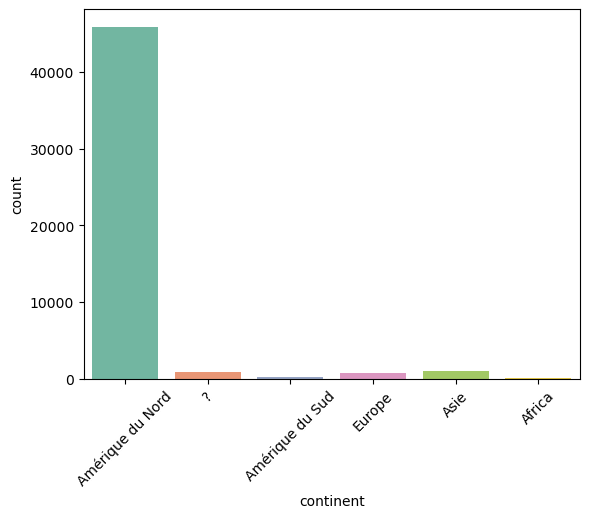

In [169]:
sns.countplot(data=df_raw, x="continent", palette="Set2")
plt.xticks(rotation=45)  # Rotation des labels de l'axe x
plt.show()

Podemos ver aqui que la mayoria son de america del norte. Veremos si esta variable aporta mucha informacion a nuestra target pero no lo pienso.

# Tratamiento

In [170]:
df_processed = df_raw.copy()

In [171]:
df_processed.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income', 'continent'],
      dtype='object')

## Tratamiento de valores faltantes (?)

In [172]:
df_processed.drop(columns=["native-country"], inplace=True)
cols_with_error = ["workclass", "occupation", "continent"]

df_processed =  df_processed[df_processed["workclass"] != "Never-worked"]
df_processed =  df_processed[df_processed["workclass"] != "Without-pay"]
df_processed =  df_processed[df_processed["race"] != "Other"]


Imputo los "?" con la moda.

In [173]:
for col in cols_with_error:
    mode = df_processed.loc[df_processed[col] != '?', col].mode()[0]
    df_processed[col] = df_processed[col].replace('?', mode)

In [174]:
print(df_processed.shape)
print(df_raw.shape)
for col in df_processed.columns:
    value_counts = df_processed[col].value_counts().head(50)
    percentage = round(value_counts/df_processed.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valeur': value_counts.index, 'Nombre': value_counts.values, 'Pourcentage': percentage.values}))
    print(f"Type {df_processed[col].dtype}")
    print("-----------------------------")

(48353, 15)
(48790, 16)
age
    Valeur  Nombre  Pourcentage
0       36    1334         2.76
1       35    1327         2.74
2       33    1320         2.73
3       31    1312         2.71
4       23    1309         2.71
5       34    1294         2.68
6       37    1271         2.63
7       30    1264         2.61
8       28    1261         2.61
9       38    1255         2.60
10      32    1234         2.55
11      41    1226         2.54
12      27    1212         2.51
13      29    1202         2.49
14      39    1198         2.48
15      24    1191         2.46
16      40    1178         2.44
17      25    1175         2.43
18      22    1165         2.41
19      42    1157         2.39
20      26    1135         2.35
21      43    1095         2.26
22      20    1093         2.26
23      45    1089         2.25
24      46    1088         2.25
25      21    1076         2.23
26      47    1071         2.21
27      44    1057         2.19
28      19    1037         2.14
29      51  

## Tratamiento de outliers

In [175]:
print(df_processed.shape)
df_processed['capital-gain'] = df_processed['capital-gain'].clip(upper=20000)
df_processed['hours-per-week'] = df_processed['hours-per-week'].clip(upper=60)
df_processed['age'] = df_processed['age'].clip(upper=65)
df_processed['capital-loss'] = df_processed['capital-loss'].clip(upper=3000)
print(df_processed.shape)

(48353, 15)
(48353, 15)


## Creacion de variable

In [176]:
df_processed["capital-gain > 500"] = (df_processed["capital-gain"] > 500).astype(int)
df_processed["capital-loss > 500"] = (df_processed["capital-loss"] > 500).astype(int)

In [177]:
cat_cols.append("capital-gain > 500")
cat_cols.append("capital-loss > 500")
cat_cols.remove("native-country")

In [178]:
df_processed["P&L"] = df_processed["capital-gain"] - df_processed["capital-loss"]
num_cols.append("P&L")

In [179]:
df_processed["race-group"] = df_processed["race"].apply(lambda x: "White" if x == "White" else "Other")
cat_cols.append("race-group")

In [180]:
def classer_secteur(x):
    if x in ["Private", "Self-emp-not-inc", "Self-emp-inc"]:
        return "Privé"
    elif x in ["Local-gov", "State-gov", "Federal-gov"]:
        return "Public"

df_processed["sector"] = df_processed["workclass"].apply(classer_secteur)
cat_cols.append("sector")

In [181]:
def categorize_age(age):
    if age < 26:
        return "Young Adult"
    elif age < 41:
        return "Adult"
    elif age < 61:
        return "Middle-aged"
    else:
        return "Senior"

df_processed["age-group"] = df_processed["age"].apply(categorize_age)
cat_cols.append("age-group")


Manejamos los outliers con una windsorizacion con datos que parecen ser mas comunes y que hemos visto en los graficos de antes. Creamos tambien dos variables par decir si una persona tiene un capital-gain de mas de 500 y misma cosa sobre capital-loss.
Creamos tambien la variable "P&L" para juntar estas dos columnas, a ver si nos da mucha informacion que capital-gain y capital-loss.

# ANALISIS BIVARIADA

In [182]:
df_processed["income"].value_counts()

income
<=50K    36724
>50K     11629
Name: count, dtype: int64

In [183]:
df_processed["income"] = df_processed["income"].replace({"<=50K": 0, ">50K": 1})

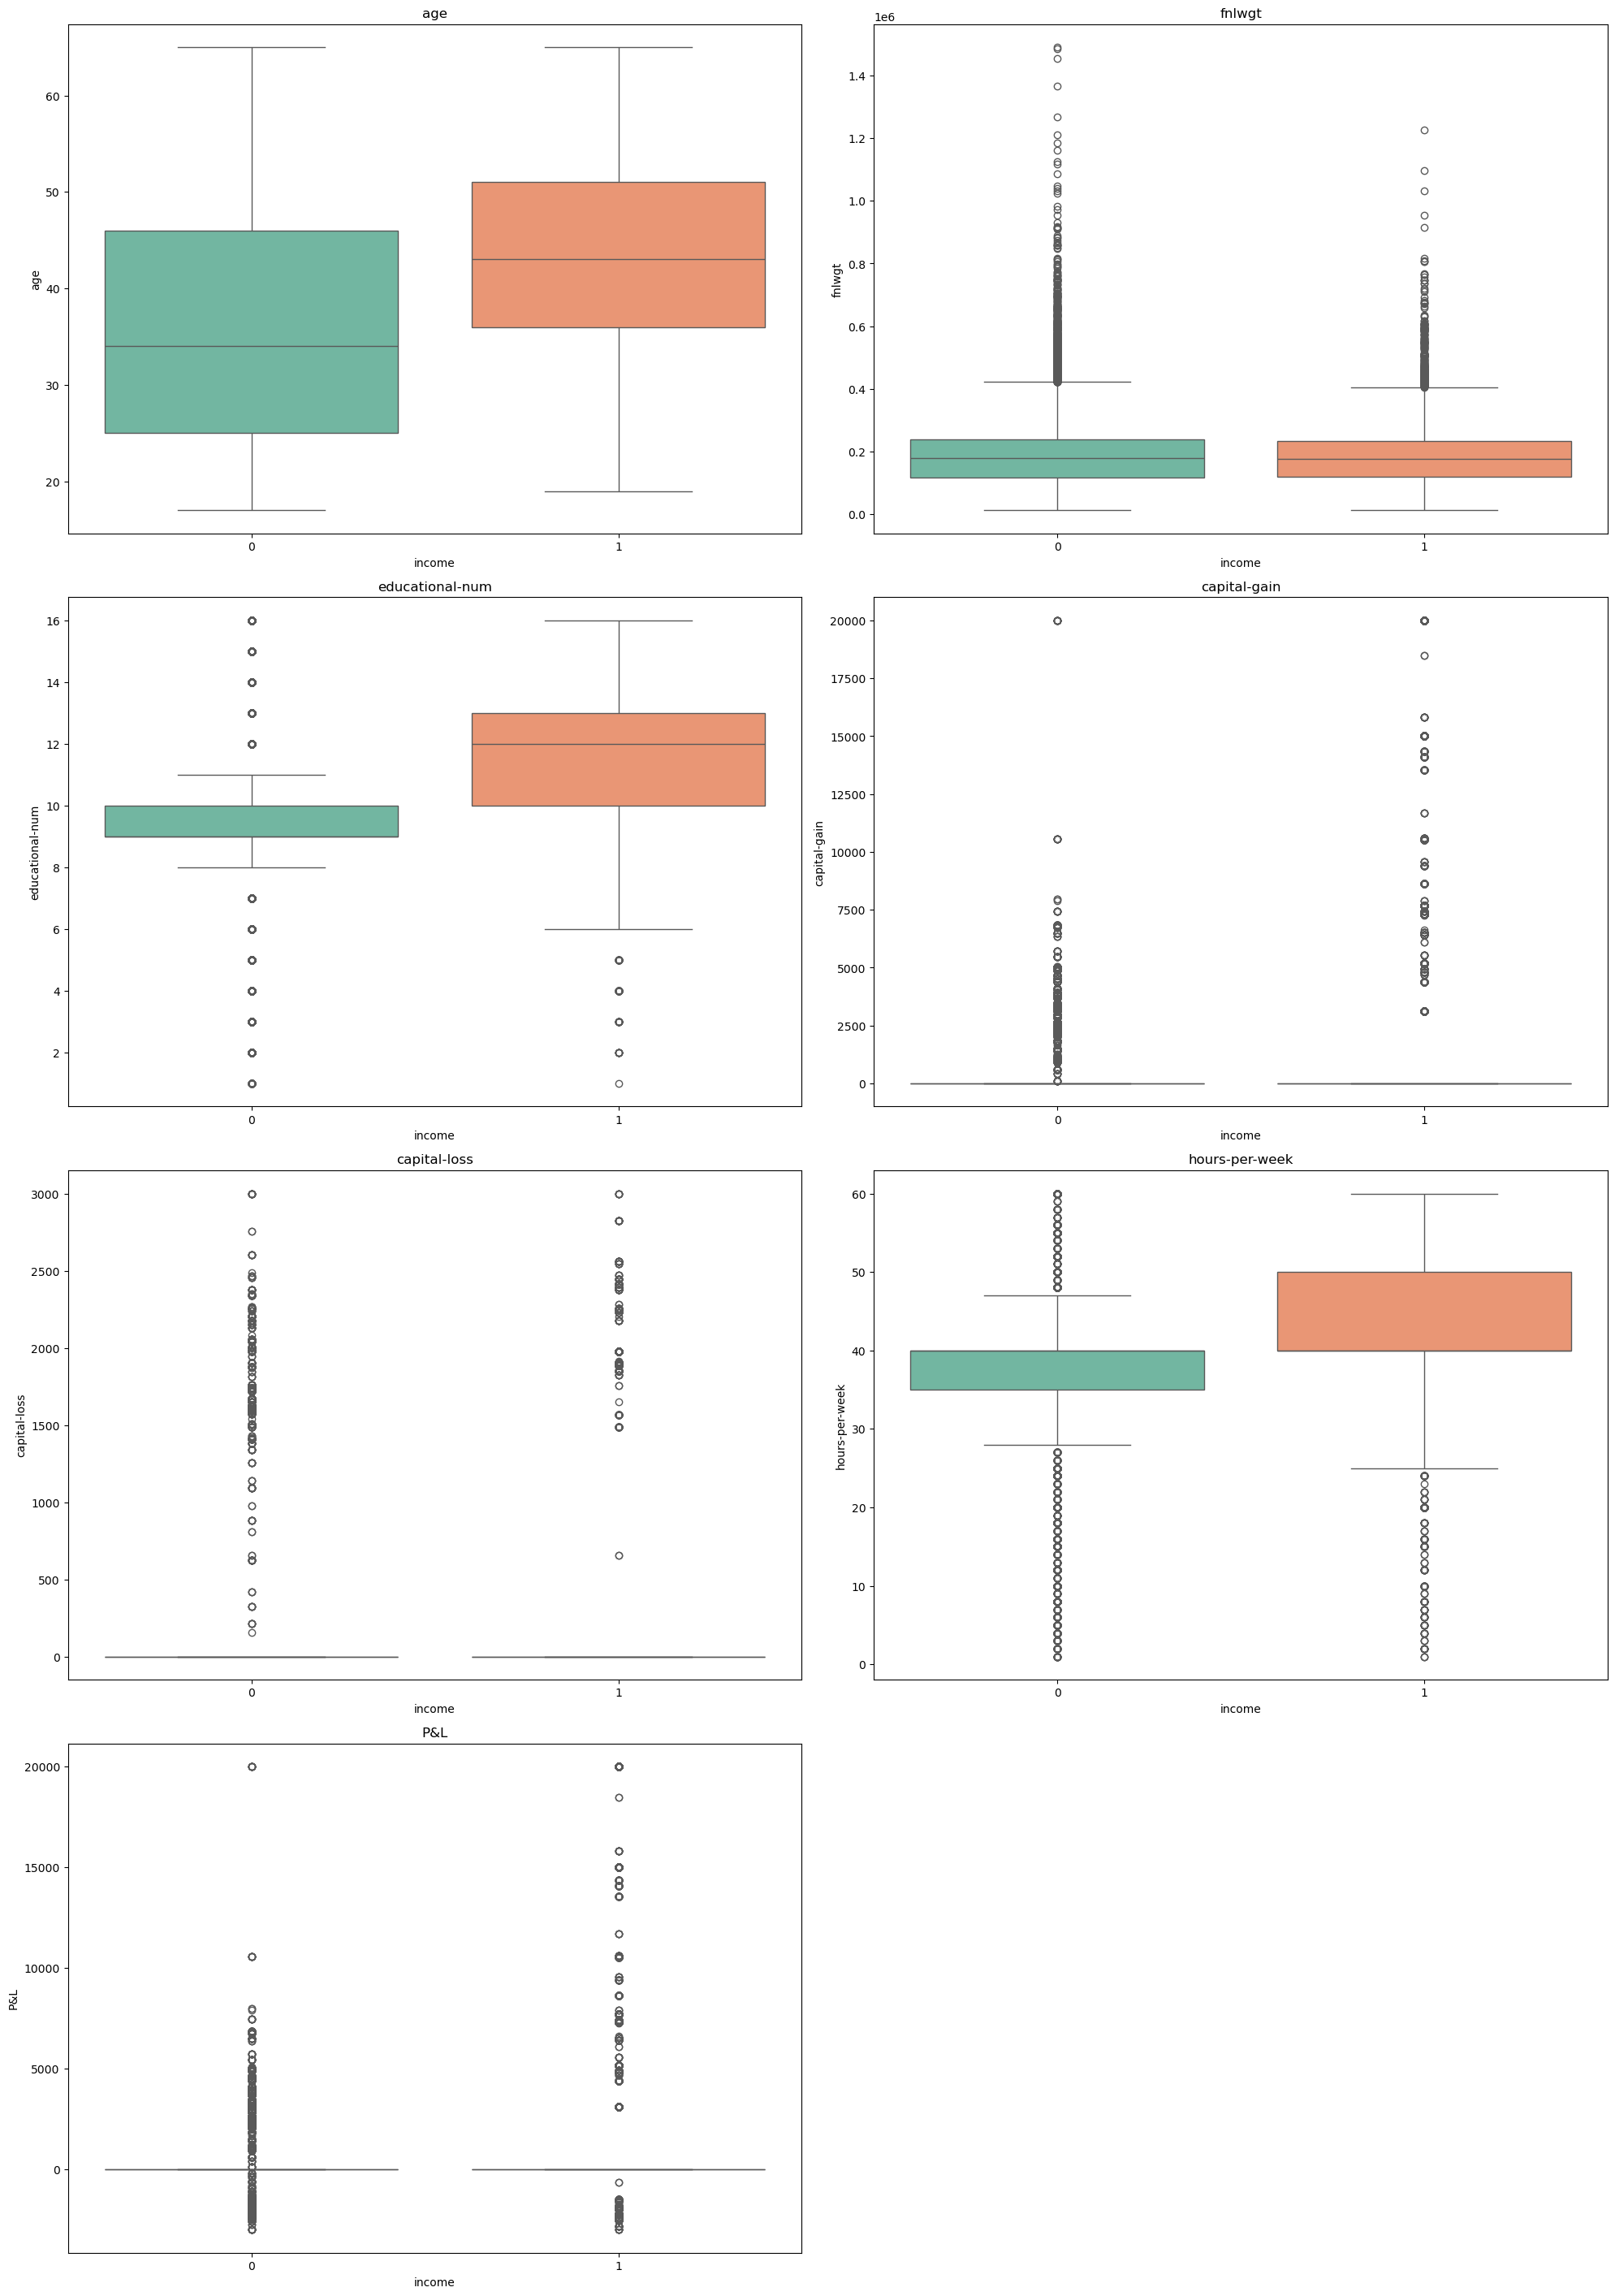

In [184]:
plt.figure(figsize=(20,35))


for i, var in enumerate(num_cols):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data = df_processed, x = 'income', y = var, palette="Set2")
    plt.title(var)


plt.tight_layout()
plt.show()

Lo que podemos ver aqui :
- cuanto mas mayor, tanto mas tiene probabilidad de tener un sueldo mayor que 50K
- Misma cosa con los anos de estudio/pretigio.
- Misma cosa con el numero de horas trabajadas a la semana.
- Pero no vemos aqui una diferencia con el capital gain y el capital loss de manera visual.

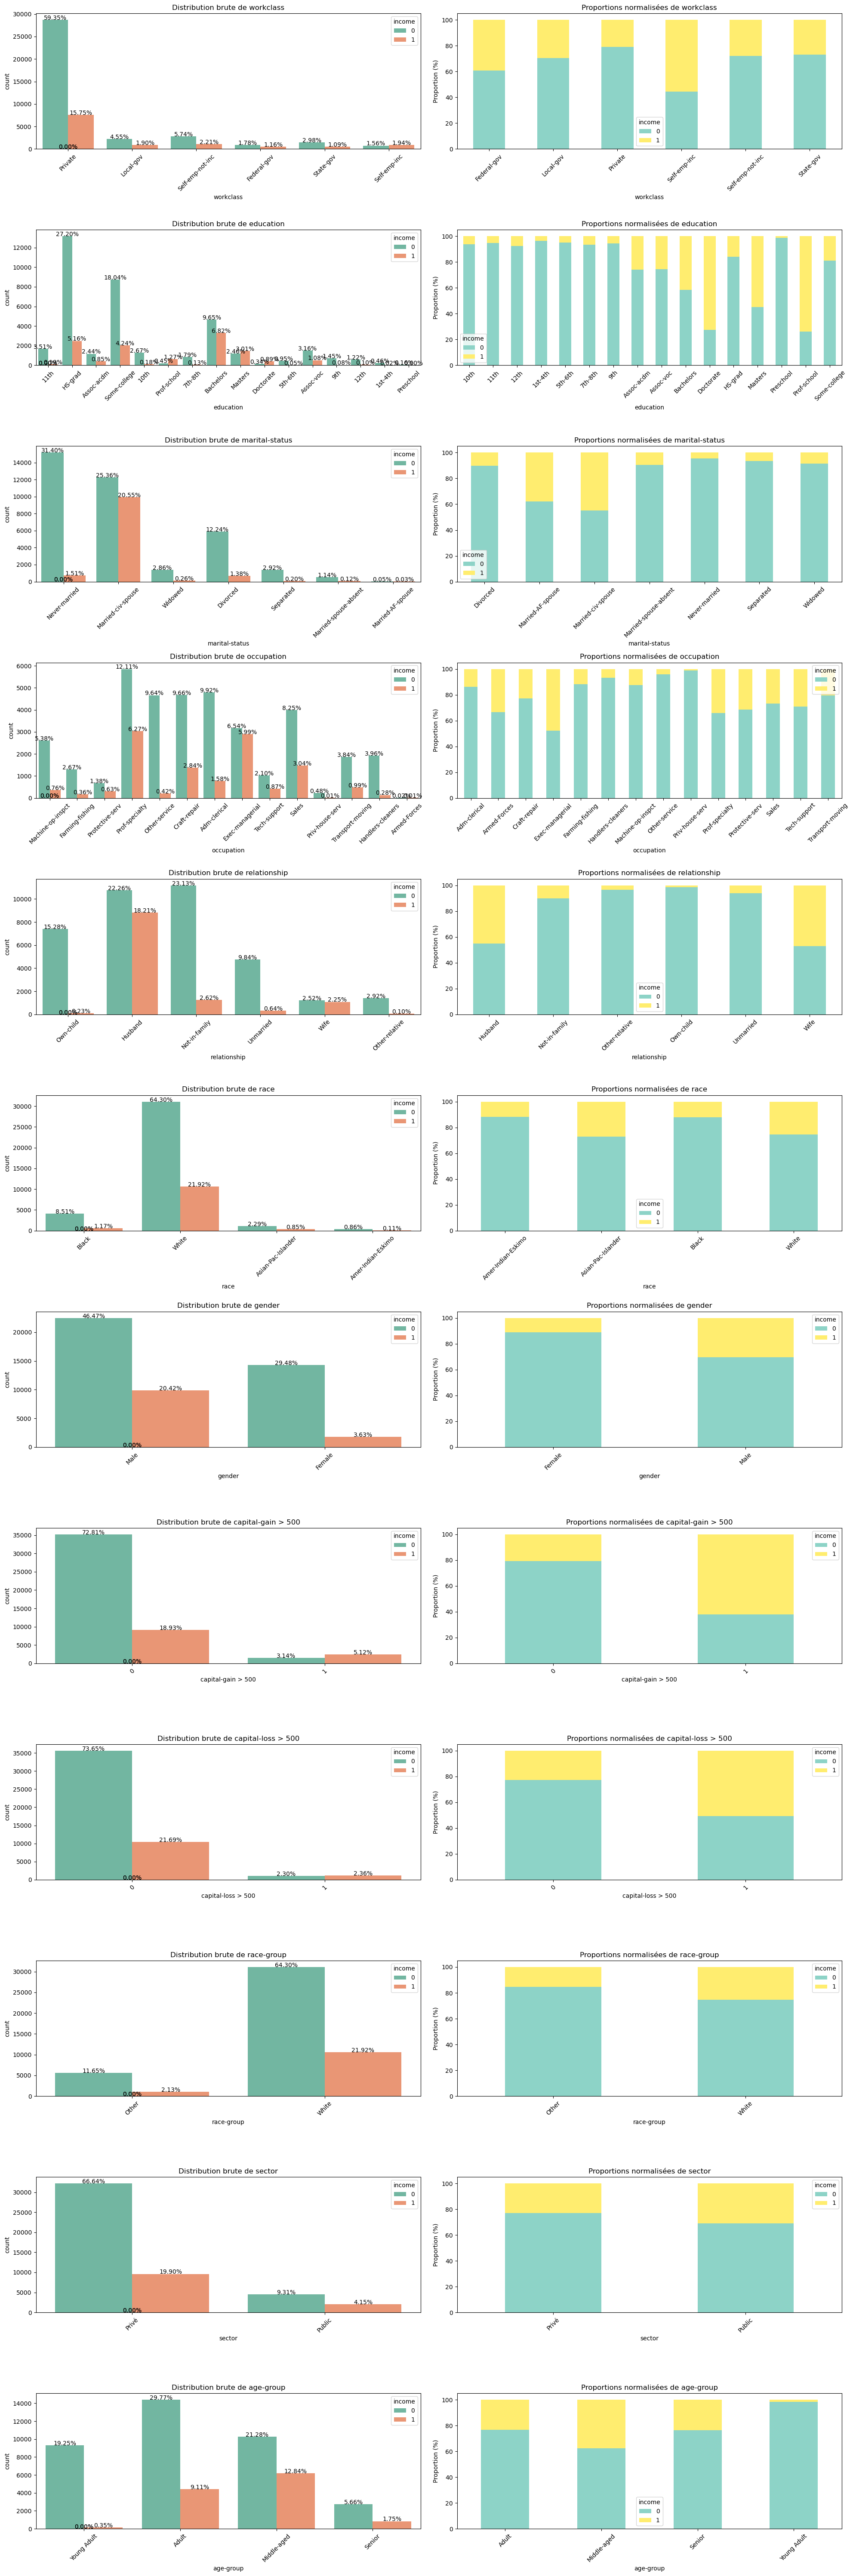

In [185]:
strg_cols_without_target = [col for col in cat_cols if col not in ['income', 'native-country']]


n = len(strg_cols_without_target)

#me inspiro de tu codigo y usé chatgpt para darme los porcentages y la parte derecha de los graficos

fig, axes = plt.subplots(n, 2, figsize=(20, n * 5))  

for i, var in enumerate(strg_cols_without_target):
    
    ax1 = axes[i, 0] if n > 1 else axes[0] 
    sns.countplot(data=df_processed, x=var, hue='income', palette="Set2", ax=ax1)
    
   
    total = len(df_processed)
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total:.2%}', ha="center")

    ax1.set_title(f"Distribution brute de {var}")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    
    ax2 = axes[i, 1] if n > 1 else axes[1] 
    crosstab = pd.crosstab(df_processed[var], df_processed["income"], normalize="index") * 100
    crosstab.plot(kind="bar", stacked=True, colormap="Set3", ax=ax2)

    ax2.set_title(f"Proportions normalisées de {var}")
    ax2.set_ylabel("Proportion (%)")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


Aqui podemos ver :

- el sector privado es donde los salario son normalmente los mas altos. Pero en proporcion, los emprendedores son los que tienen una mayor probabilidad de tener un salario de mas de 50K. Y en proporcion es en el publico donde es mas probable de tener un salario alto.
- Los bachelors, Doctorate, Masters y los prof-schools son los con mayor probabilidad de tener un salario muy alto.
- Una pareja solida es muy importante para tener une salario alto.
- Los mejores ocupaciones son prof specialty y executive-managerial
- Tenemos que analizar si marital-status y relationship no comparten la misma informacion
- Parece de manera visual que donde ha sido hecha la encuesta no hay problema entre todas las razas pero entre los blancos y los otros parece haber una diferencia pero pequena
- Por lo contrario parece que tenemos un problema de genero.
- He cread dos variables a partir de capital-gain y capital loss (1 si es alto de 500) : Tenemos una gran parte de la populacion que no inverte pero lo que lo hacen tienen mas suerte de tener un sueldo de mas de 50K. Misma cosa sobre el capital-loss. Se puede decir con cuidado que las personas con una propension a invertir tiene mas suerte de tener un salario alto.
- Por fin, al mirar los grupos de edad, el middled-age es el grupo con mas de personas con un salario alto y en proporcion tambien.

# ANALISIS MULTIVARIADA

In [186]:
num_cols_with_target = list(num_cols) + ["income"]

#sns.pairplot(df_processed[num_cols_with_target], diag_kind='kde', hue="income")
#plt.show()

In [187]:
df_raw[df_raw["capital-loss"] >500]["native-country"].value_counts().sort_index(ascending=False)    

native-country
Vietnam                          4
United-States                 2068
Trinadad&Tobago                  2
Thailand                         1
Taiwan                           4
South                            8
Puerto-Rico                      9
Poland                           3
Philippines                     13
Peru                             1
Outlying-US(Guam-USVI-etc)       1
Nicaragua                        2
Mexico                          16
Laos                             1
Japan                            3
Jamaica                          1
Italy                            3
Ireland                          2
Iran                             4
India                            9
Hungary                          1
Hong                             4
Honduras                         2
Holand-Netherlands               1
Haiti                            3
Guatemala                        1
Greece                           4
Germany                          7
Franc

No veo muchas cosas interesentes excepto por la variable P&L que he creado. Se puede ver una relacion lineal entre el P&L y capital-gain y capital-loss. Se puede ver que una persona con una gran propension a invertir tiene mas suerte de tener un saldo mayor a 50K. 

## CORRELACIONES

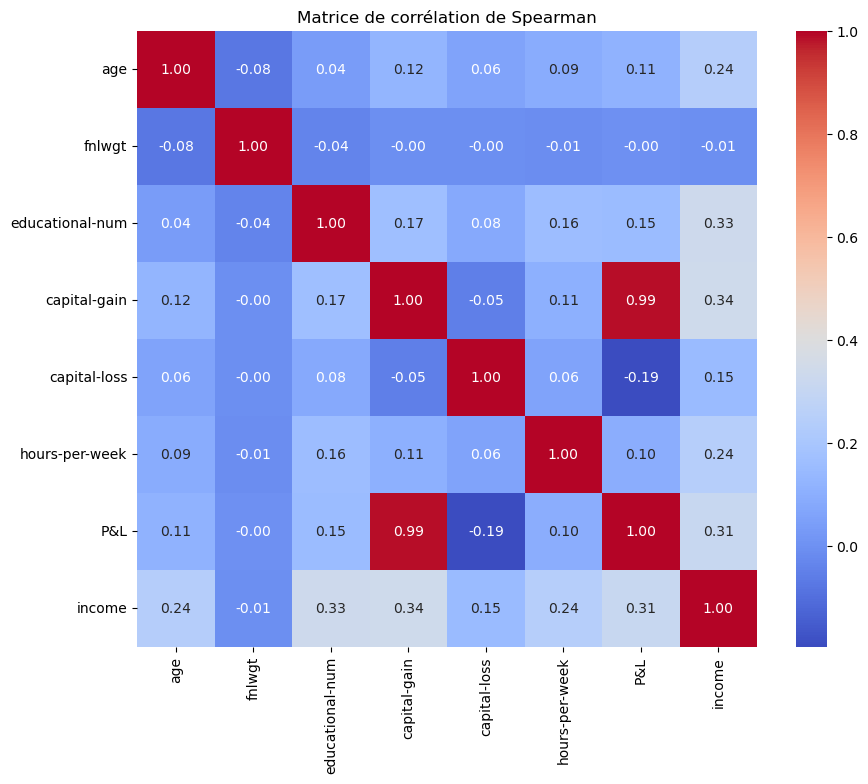

In [188]:
plt.figure(figsize=(10, 8))
corr = df_processed[num_cols_with_target].corr(method='pearson')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

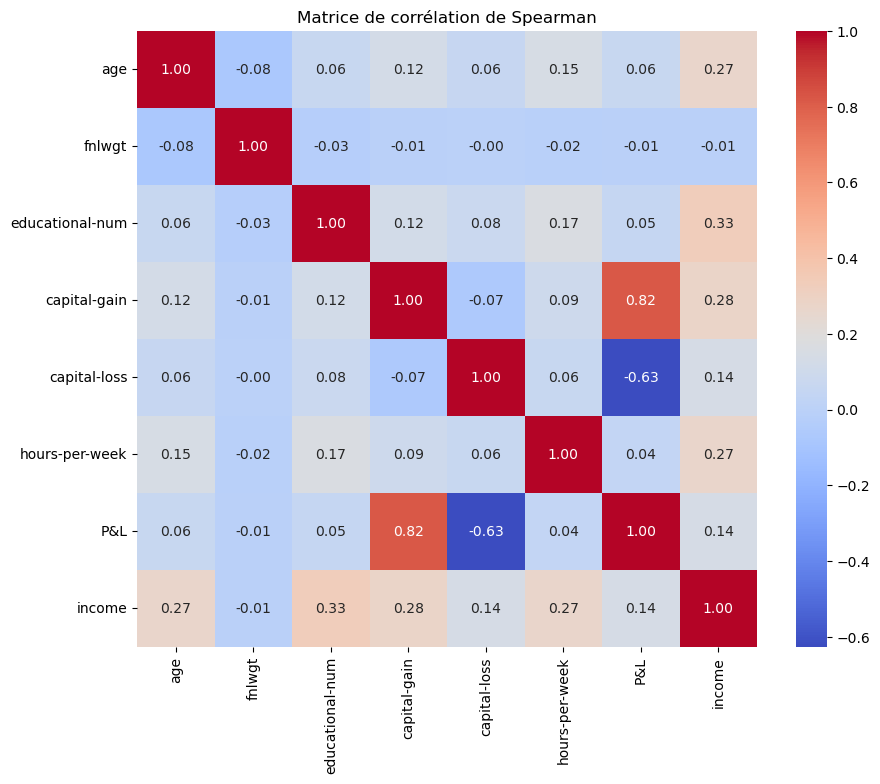

In [189]:
plt.figure(figsize=(10, 8))
corr = df_processed[num_cols_with_target].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

Podemos ver que puede ser bien de guardar la variable P&L porque permite agrupar la informacion de capital-gain y capital-loss. Tenemos coeficientes mas alto con spearman que con pearson asi tenemos algunos outliers.

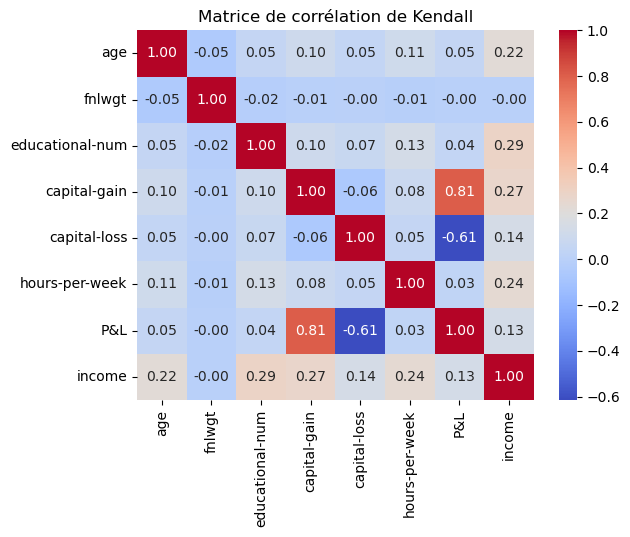

In [190]:
kendall_results = pd.DataFrame(index=num_cols_with_target, columns=num_cols_with_target)
p_values = pd.DataFrame(index=num_cols_with_target, columns=num_cols_with_target)

for col1 in num_cols_with_target:
    for col2 in num_cols_with_target:
        tau, p_value = kendalltau(df_processed[col1], df_processed[col2])
        kendall_results.loc[col1, col2] = tau
        p_values.loc[col1, col2] = p_value

kendall_results = kendall_results.astype(float)
p_values = p_values.astype(float)
sns.heatmap(kendall_results, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Kendall")
plt.show()


In [191]:
df_corr = df_processed[["capital-gain > 500", "capital-loss > 500", "P&L"]]
corr_matrix = df_corr.corr(method='spearman')
print(corr_matrix)

                    capital-gain > 500  capital-loss > 500       P&L
capital-gain > 500            1.000000           -0.066356  0.816778
capital-loss > 500           -0.066356            1.000000 -0.624958
P&L                           0.816778           -0.624958  1.000000


Veremos si capita-gain > 500 et capital-loss > 500 sirven o sino eliminaré las dos porque tengo mucha correlacion y P&L parece mejor.

## CHI2

In [192]:
# tu codigo
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p
def analyze_categorical_relationships(df, categorical_cols):
    results = []
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            col1 = categorical_cols[i]
            col2 = categorical_cols[j]
            chi2, p = chi_square_test(df, col1, col2)
            results.append((col1, col2, chi2, p))
    return results

categorical_relationships = analyze_categorical_relationships(df_processed, cat_cols)
results_df = pd.DataFrame(categorical_relationships, columns=['col1', 'col2', 'chi2', 'p-value'])
results_df['significant'] = results_df['p-value'] < 0.05

results_df['p-value'] = results_df['p-value'].apply(lambda x: '{:.2e}'.format(x))
results_df['chi2'] = results_df['chi2'].apply(lambda x: '{:.2f}'.format(x))
results_df['chi2'] = results_df['chi2'].astype('float')
results_df.sort_values(by='chi2', ascending=False, inplace=True)
pd.set_option('display.max_rows', None)
results_df

,col1,col2,chi2,p-value,significant
24,marital-status,relationship,57732.24,0.00e+00,True
10,workclass,sector,48353.00,0.00e+00,True
54,race,race-group,48353.00,0.00e+00,True
32,marital-status,age-group,21329.84,0.00e+00,True
43,relationship,gender,20256.72,0.00e+00,True
13,education,occupation,18313.58,0.00e+00,True
49,relationship,age-group,16763.25,0.00e+00,True
2,workclass,occupation,12110.24,0.00e+00,True
26,marital-status,gender,10255.87,0.00e+00,True
44,relationship,income,10019.43,0.00e+00,True


In [193]:
def cramers_v(x, y):
    """
    Calcula Cramér's V para dos variables categóricas.
    
    Parámetros:
    - x, y: Series o arrays de pandas que representan variables categóricas.
    
    Retorna:
    - Valor de Cramér's V, entre 0 y 1.
    """
    tabla_cruzada = pd.crosstab(x, y)

    chi2, p, dof, expected = chi2_contingency(tabla_cruzada)
    
    n = tabla_cruzada.sum().sum()
    min_dim = min(tabla_cruzada.shape) - 1
    if min_dim == 0:
        return np.nan 
    
    return np.sqrt(chi2 / (n * min_dim))


cramers_v_results = []
for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        col1 = cat_cols[i]
        col2 = cat_cols[j]
        cv = cramers_v(df_processed[col1], df_processed[col2])
        cramers_v_results.append((col1, col2, cv))
cramers_v_df = pd.DataFrame(cramers_v_results, columns=['col1', 'col2', 'Cramér\'s V'])
cramers_v_df['Cramér\'s V'] = cramers_v_df['Cramér\'s V'].apply(lambda x: '{:.2f}'.format(x))
cramers_v_df.sort_values(by='Cramér\'s V', ascending=False, inplace=True)
cramers_v_df.head(60)

,col1,col2,Cramér's V
54,race,race-group,1.00
10,workclass,sector,1.00
43,relationship,gender,0.65
24,marital-status,relationship,0.49
26,marital-status,gender,0.46
44,relationship,income,0.46
27,marital-status,income,0.45
35,occupation,gender,0.42
32,marital-status,age-group,0.38
17,education,income,0.37


Tenemos un V de Cramer muy fuerte entre relationship y gender y guardaremos relationship porque permite dar mas informaciones sobre nuestra target. Y misma cosa con marital-status, asi guardamos relationship. Y como lo hemos visto el V de Cramer entre race y el income es debil y misma cosa con el genero asi aqui no tenemos muchos sesgo al final.

In [194]:
filtered_df = cramers_v_df[(cramers_v_df['col1'] == 'income') | (cramers_v_df['col2'] == 'income')]
filtered_df.sort_values(by='Cramér\'s V', ascending=False, inplace=True)
filtered_df.head(60)

,col1,col2,Cramér's V
44,relationship,income,0.46
27,marital-status,income,0.45
17,education,income,0.37
36,occupation,income,0.31
67,income,age-group,0.30
63,income,capital-gain > 500,0.27
57,gender,income,0.22
6,workclass,income,0.17
64,income,capital-loss > 500,0.14
51,race,income,0.10


La nueva variable race_group parece ser casi igual a race al mirar su relacion con la target. La variable sector tampoco no aporta mucha informacion.

In [195]:
df_processed.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'continent',
       'capital-gain > 500', 'capital-loss > 500', 'P&L', 'race-group',
       'sector', 'age-group'],
      dtype='object')

In [196]:
contingency_table = pd.crosstab(df_processed["education"], df_processed["educational-num"])
chi2, p, _, _ = chi2_contingency(contingency_table)

if p < 0.05:
    print("Il existe une association significative entre education et educational-num.")
else:
    print("Pas d'association significative entre education et educational-num.")

n = contingency_table.sum().sum()
r, k = contingency_table.shape

cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))

print(f"V de Cramér : {cramers_v:.4f}")

Il existe une association significative entre education et educational-num.
V de Cramér : 1.0000


Como lo hemos visto, podremos tambien eliminar education.

## ANOVA

In [197]:
for col in num_cols:
    # Sélectionner les différentes classes de la variable cible
    groups = [df_processed[df_processed["income"] == category][col] for category in df_processed["income"].unique()]

    # Appliquer le test ANOVA
    anova_result = f_oneway(*groups)
    # Interprétation
    if anova_result.pvalue < 0.05:
        print(f"Il y a une différence significative entre le niveau de salaire et {col}.")
    else:
        print(f"Aucune différence significative entre le niveau de salaire et {col}.")


Il y a une différence significative entre le niveau de salaire et age.
Aucune différence significative entre le niveau de salaire et fnlwgt.
Il y a une différence significative entre le niveau de salaire et educational-num.
Il y a une différence significative entre le niveau de salaire et capital-gain.
Il y a une différence significative entre le niveau de salaire et capital-loss.
Il y a une différence significative entre le niveau de salaire et hours-per-week.
Il y a une différence significative entre le niveau de salaire et P&L.


In [198]:
for col in num_cols:
    # Sélectionner les différentes classes de la variable cible
    groups = [df_processed[df_processed["income"] == category][col] for category in df_processed["income"].unique()]

    # Appliquer le test ANOVA
    stat, p_value = kruskal(*groups)
    # Interprétation
    if p_value < 0.05:
        print(f"Il y a une différence significative entre le niveau de salaire et {col}.")
    else:
        print(f"Aucune différence significative entre le niveau de salaire et {col}.")


Il y a une différence significative entre le niveau de salaire et age.
Aucune différence significative entre le niveau de salaire et fnlwgt.
Il y a une différence significative entre le niveau de salaire et educational-num.
Il y a une différence significative entre le niveau de salaire et capital-gain.
Il y a une différence significative entre le niveau de salaire et capital-loss.
Il y a une différence significative entre le niveau de salaire et hours-per-week.
Il y a une différence significative entre le niveau de salaire et P&L.


Lo sabiamos que la variable fnlwgt no da informacion sobre nuestra target pero veremos si no se puede utilisar para dar mas representatividad.

## Mutual information

In [199]:
df_processed.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'continent',
       'capital-gain > 500', 'capital-loss > 500', 'P&L', 'race-group',
       'sector', 'age-group'],
      dtype='object')

In [200]:
df_mutinf = df_processed.drop(columns=["fnlwgt","education"]).copy()
cat_cols_target = ["workclass", "marital-status", "occupation", "relationship", "continent"]
cat_cols_onehot = ["race", "gender","capital-gain > 500", "capital-loss > 500", "sector", "age-group","race-group"]

for col in cat_cols_target:
    encoder = TargetEncoder(cols=[col])
    df_mutinf[col] = encoder.fit_transform(df_mutinf[col],df_processed['income'])


encoder = OneHotEncoder(sparse_output =False,handle_unknown='ignore')
encoded_array = encoder.fit_transform(df_mutinf[cat_cols_onehot])
df_dummies = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols_onehot))
print(df_dummies.shape)
df_mutinf = df_mutinf.reset_index(drop=True)
df_dummies = df_dummies.reset_index(drop=True)
df_mutinf = pd.concat([df_mutinf.drop(columns=cat_cols_onehot), df_dummies], axis=1)
df_mutinf.head()
print(df_mutinf.shape)


(48353, 18)
(48353, 30)


In [201]:
X = df_mutinf.drop(columns=["income"])
target = df_mutinf["income"]
mi_categorical = mutual_info_classif(X, target, random_state=42)
mi_series = pd.Series(mi_categorical, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)
print(mi_series)

flop = mi_series[mi_series < 0.1]
top  = mi_series[mi_series > 0.3]
print("-------------------")
print("Top",top)
print("-------------------")
print("Flop",flop)

P&L                        0.120919
relationship               0.120531
marital-status             0.111530
capital-gain               0.080091
educational-num            0.067849
age                        0.066027
occupation                 0.052068
age-group_Young Adult      0.046835
hours-per-week             0.043497
capital-gain > 500_0       0.037393
capital-loss               0.035094
capital-gain > 500_1       0.031289
gender_Male                0.030388
gender_Female              0.027135
age-group_Middle-aged      0.026128
workclass                  0.019851
capital-loss > 500_0       0.017772
continent                  0.009615
race_White                 0.009557
race-group_White           0.009173
sector_Privé               0.008347
capital-loss > 500_1       0.006368
race_Black                 0.006283
age-group_Adult            0.004502
race-group_Other           0.004028
sector_Public              0.003266
age-group_Senior           0.002980
race_Asian-Pac-Islander    0

In [202]:
mi_series

# separamos columnas y valores y sumamos importancia
mi_series_grouped = mi_series.groupby(lambda x: x.split('_')[0]).sum().reset_index()
mi_series_grouped.sort_values(by=0, ascending=False).reset_index(drop=True).rename(columns={'index': 'col_name', 0: 'importance'}).style.background_gradient(cmap='coolwarm')

,col_name,importance
0,P&L,0.120919
1,relationship,0.120531
2,marital-status,0.111530
3,age-group,0.080445
4,capital-gain,0.080091
5,capital-gain > 500,0.068682
6,educational-num,0.067849
7,age,0.066027
8,gender,0.057523
9,occupation,0.052068


- Las variables race, continent y workclass parece no aportar muchas informaciones. Pero al contrario P&L, relationship y marital-status apportan muchas informaciones. Voy a guardar P&L y eliminar capital-loss > 500 y capital-gain > 500.
- las nuevas variables no parecen ser mejores que la variabe original excepto age-group pero vamos a probar luego de las cuales entre las nuevas y las originales son mejores para predecir la target. 

In [204]:
# Con este parte quiero comparar la informacion mutua entre todas las variables y no solo con la variable target
cols = df_mutinf.select_dtypes(include=['object', 'int64', 'float64']).columns 


mi_matrix = pd.DataFrame(columns=cols, index=cols)

for col1 in cols:
    for col2 in cols:
        if col1 != col2:
            
            mi_matrix.loc[col1, col2] = mutual_info_regression(df_mutinf[[col1]], df_mutinf[col2])[0]


print(mi_matrix)

                              age workclass educational-num marital-status  \
age                           NaN  0.037761        0.100756       0.241783   
workclass                0.035394       NaN        0.028869       0.011041   
educational-num          0.098203  0.027738             NaN       0.018478   
marital-status           0.239905  0.019546        0.021054            NaN   
occupation               0.044392   0.09915        0.178302       0.048741   
relationship             0.196697  0.018926        0.041581       0.725701   
capital-gain             0.035321  0.009018        0.015353       0.061986   
capital-loss             0.016818  0.004096        0.009866       0.039268   
hours-per-week           0.103324  0.033631        0.034524       0.047657   
income                   0.068302  0.013444        0.066595        0.10895   
continent                       0         0        0.006547       0.010196   
P&L                      0.054922   0.01491         0.03511     

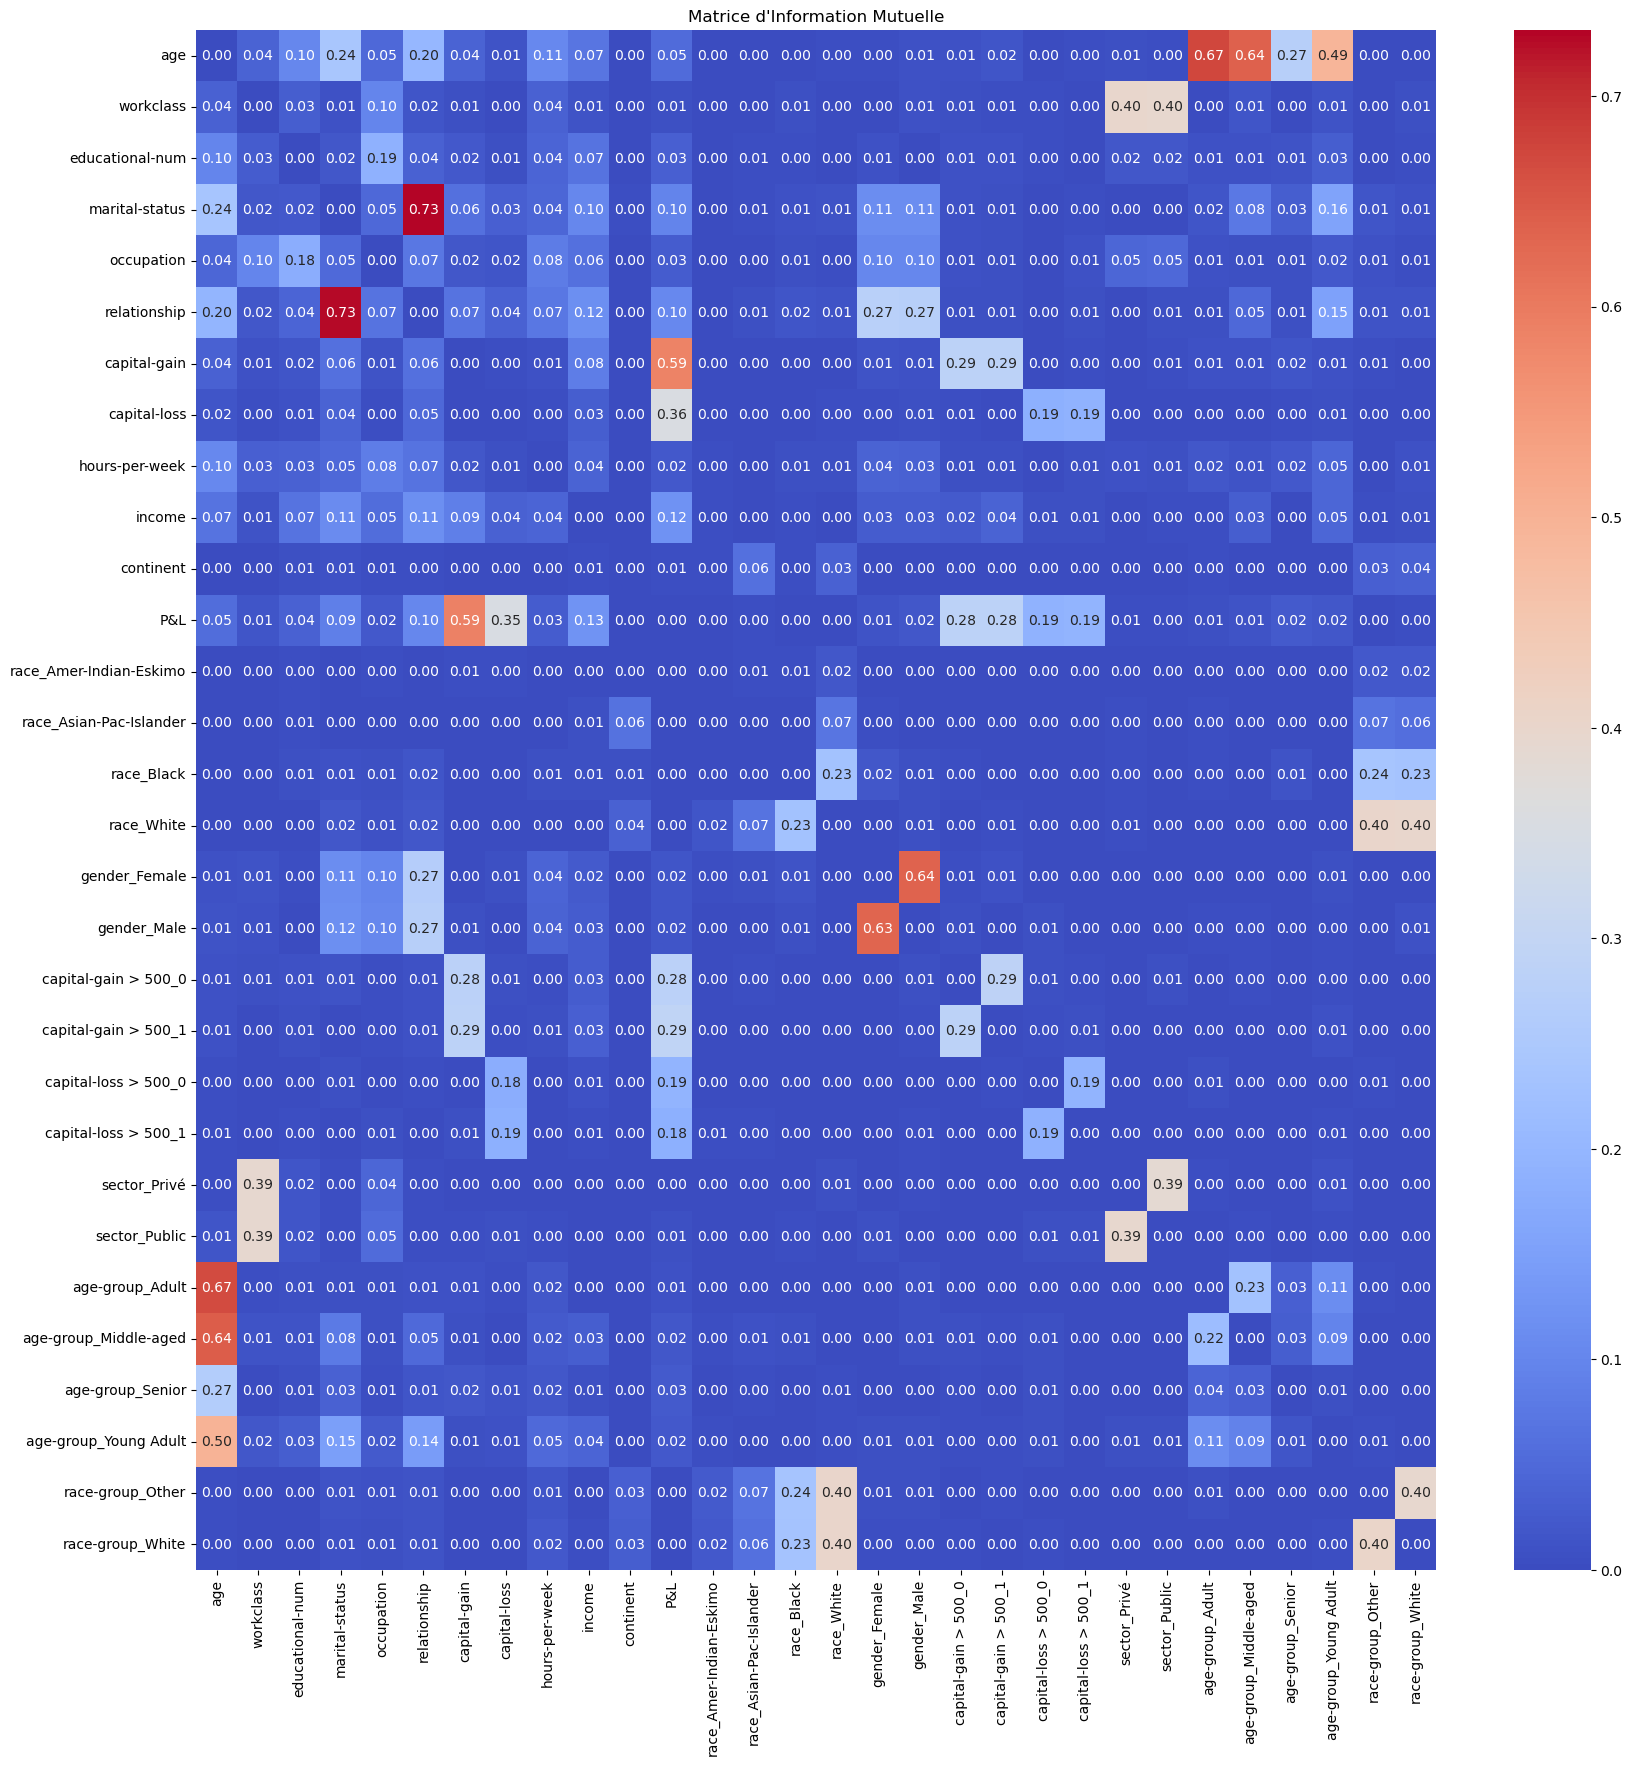

In [213]:

mi_matrix = mi_matrix.apply(pd.to_numeric, errors='coerce')

mi_matrix = mi_matrix.fillna(0)


plt.figure(figsize=(20, 20))
sns.heatmap(mi_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice d'Information Mutuelle")
plt.show()


In [206]:
df_processed.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'continent',
       'capital-gain > 500', 'capital-loss > 500', 'P&L', 'race-group',
       'sector', 'age-group'],
      dtype='object')

Vemos de nuevo que podemos eliminar marital-status porque tenemos une problema con relationship. Como relationship tiene un V de Cramer mas alto con la target guardamos esta variable.

Vamos a eliminar : "fnlwgt", "education", "marital-status", "capital-gain > 500", "capital-loss > 500", "capital-loss", "capital-gain" y "gender" aunque la multicolinealidad no esta perfecta porque hay mas grupos en relationship. Con mas datos de mujeres poderiamos ver si hubo un real relacion con la target. 

## PCA

In [214]:

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_mutinf.drop(columns=["income"]))  # Suppression de la variable cible
X_scaled = pd.DataFrame(X_scaled, columns=df_mutinf.drop(columns=["income"]).columns)
# Application de PCA
pca = PCA(n_components=2)  # Le nombre de composantes doit être égal au nombre de variables
pca.fit(X_scaled)

# Analyse des valeurs propres
comp = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(2)],  # Le nombre de dimensions doit être égal au nombre de variables
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100, 2),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)

# Afficher le résultat
print(comp)


  Dimension  Valeur propre  % variance expliquée  % cum. var. expliquée
0      Dim1   1.543081e+07                 98.48                  98.48
1      Dim2   2.384818e+05                  1.52                 100.00


In [215]:
# Calculer la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2)

# Convertir les contributions en pourcentage
variable_contrib_percent = variable_contributions * 100

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'PC{i+1}_contrib' for i in range(2)]
variable_contrib_df = pd.DataFrame(variable_contrib_percent, columns=column_names, index=X_scaled.columns)

print(variable_contrib_df.sort_values(by='PC1_contrib', ascending=False))

                          PC1_contrib   PC2_contrib
P&L                      5.090851e+01  1.575815e+01
capital-gain             4.907467e+01  1.759198e+01
capital-loss             1.681910e-02  6.664981e+01
hours-per-week           3.333913e-07  1.055628e-05
capital-gain > 500_1     3.192394e-07  4.356897e-08
capital-gain > 500_0     3.192394e-07  4.356897e-08
educational-num          1.225443e-07  3.227705e-06
occupation               4.693500e-08  1.478571e-06
age                      3.986298e-08  9.583711e-07
relationship             2.535330e-08  9.823554e-07
marital-status           2.166650e-08  8.208067e-07
age-group_Middle-aged    9.338879e-09  2.973222e-07
age-group_Young Adult    9.026645e-09  3.184090e-07
gender_Male              6.342677e-09  2.831986e-07
gender_Female            6.342677e-09  2.831986e-07
capital-loss > 500_0     4.596513e-09  1.777280e-05
capital-loss > 500_1     4.596513e-09  1.777280e-05
age-group_Adult          1.180899e-09  6.614125e-09
age-group_Se

Lo que se observa aqui es que la primera componente principal aporta el 97 % de la varianza, y que las variables más importantes para explicar dicha varianza son P&L, horas por semana, nivel educativo (educational-num) y edad.

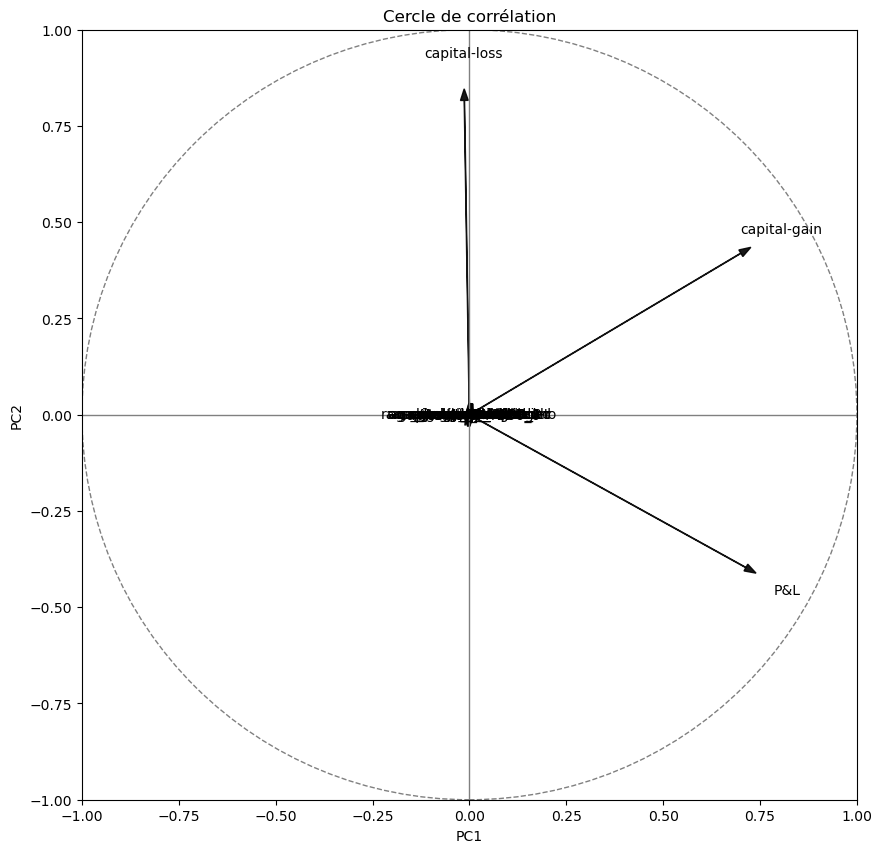

In [216]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(10, 10))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, X_scaled.columns[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation')

# Afficher la figure
plt.show()

Con un PCA con las dos primeras dimensiones, so ve muchas cosas pero se ve muy bien que la variable P&L es muy importante en nuestro contexto

# Best new variable to keep

In [210]:
encoder_workclass = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['workclass'])],
    remainder='drop'
)

encoder_secteur = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['sector'])],
    remainder='drop'
)

model = LogisticRegression(max_iter=1000)

pipe_wc = make_pipeline(encoder_workclass, model)
score_wc = cross_val_score(pipe_wc, df_processed[['workclass']], df_processed['income'], cv=5, scoring='accuracy').mean()


pipe_sec = make_pipeline(encoder_secteur, model)
score_sec = cross_val_score(pipe_sec, df_processed[['sector']], df_processed['income'], cv=5, scoring='accuracy').mean()

print(f"Accuracy with workclass: {score_wc:.3f}")
print(f"Accuracy with secteur : {score_sec:.3f}")


Accuracy with workclass: 0.763
Accuracy with secteur : 0.759


In [211]:
df_processed.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'income', 'continent',
       'capital-gain > 500', 'capital-loss > 500', 'P&L', 'race-group',
       'sector', 'age-group'],
      dtype='object')

In [218]:
encoder_race = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['race'])],
    remainder='drop'
)

encoder_race_group = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['race-group'])],
    remainder='drop'
)

model = LogisticRegression(max_iter=1000)

pipe_wc = make_pipeline(encoder_race, model)
score_wc = cross_val_score(pipe_wc, df_processed[['race']], df_processed['income'], cv=5, scoring='accuracy').mean()


pipe_sec = make_pipeline(encoder_race_group, model)
score_sec = cross_val_score(pipe_sec, df_processed[['race-group']], df_processed['income'], cv=5, scoring='accuracy').mean()

print(f"Accuracy with race: {score_wc:.3f}")
print(f"Accuracy with race_group : {score_sec:.3f}")


Accuracy with race: 0.759
Accuracy with race_group : 0.759


In [219]:
encoder_age_group = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['age-group'])],
    remainder='drop'
)


model = LogisticRegression(max_iter=1000)

pipe_wc = make_pipeline(encoder_age_group, model)
score_wc = cross_val_score(pipe_wc, df_processed[['age-group']], df_processed['income'], cv=5, scoring='accuracy').mean()


score_sec = cross_val_score(model, df_processed[['age']], df_processed['income'], cv=5, scoring='accuracy').mean()

print(f"Accuracy with age_group: {score_wc:.3f}")
print(f"Accuracy with age : {score_sec:.3f}")


Accuracy with age_group: 0.759
Accuracy with age : 0.759


Vamos a guardar de esta manera age, race-group and workclass. Hemos visto en la informacion mutua que age-group estaba mejor pero para la prediccion no tan y age nos permite tener mas granularidad. Para race, hemos visto que tenemos un dataset desbalanceado asi guardar race-group no parece tan malo.

# Final

In [220]:
df_cleaned = df_processed.copy()
df_cleaned = df_cleaned.drop(columns=['fnlwgt', 'education', 'marital-status', 'capital-gain > 500', 'capital-loss > 500', 'capital-loss', 'capital-gain', 'gender',"age-group","race","sector"])
df_cleaned.head(10)

,age,workclass,educational-num,occupation,relationship,hours-per-week,income,continent,P&L,race-group
0,25,Private,7,Machine-op-inspct,Own-child,40,0,Amérique du Nord,0,Other
1,38,Private,9,Farming-fishing,Husband,50,0,Amérique du Nord,0,White
2,28,Local-gov,12,Protective-serv,Husband,40,1,Amérique du Nord,0,White
3,44,Private,10,Machine-op-inspct,Husband,40,1,Amérique du Nord,7688,Other
4,18,Private,10,Prof-specialty,Own-child,30,0,Amérique du Nord,0,White
5,34,Private,6,Other-service,Not-in-family,30,0,Amérique du Nord,0,White
6,29,Private,9,Prof-specialty,Unmarried,40,0,Amérique du Nord,0,Other
7,63,Self-emp-not-inc,15,Prof-specialty,Husband,32,1,Amérique du Nord,3103,White
8,24,Private,10,Other-service,Unmarried,40,0,Amérique du Nord,0,White
9,55,Private,4,Craft-repair,Husband,10,0,Amérique du Nord,0,White


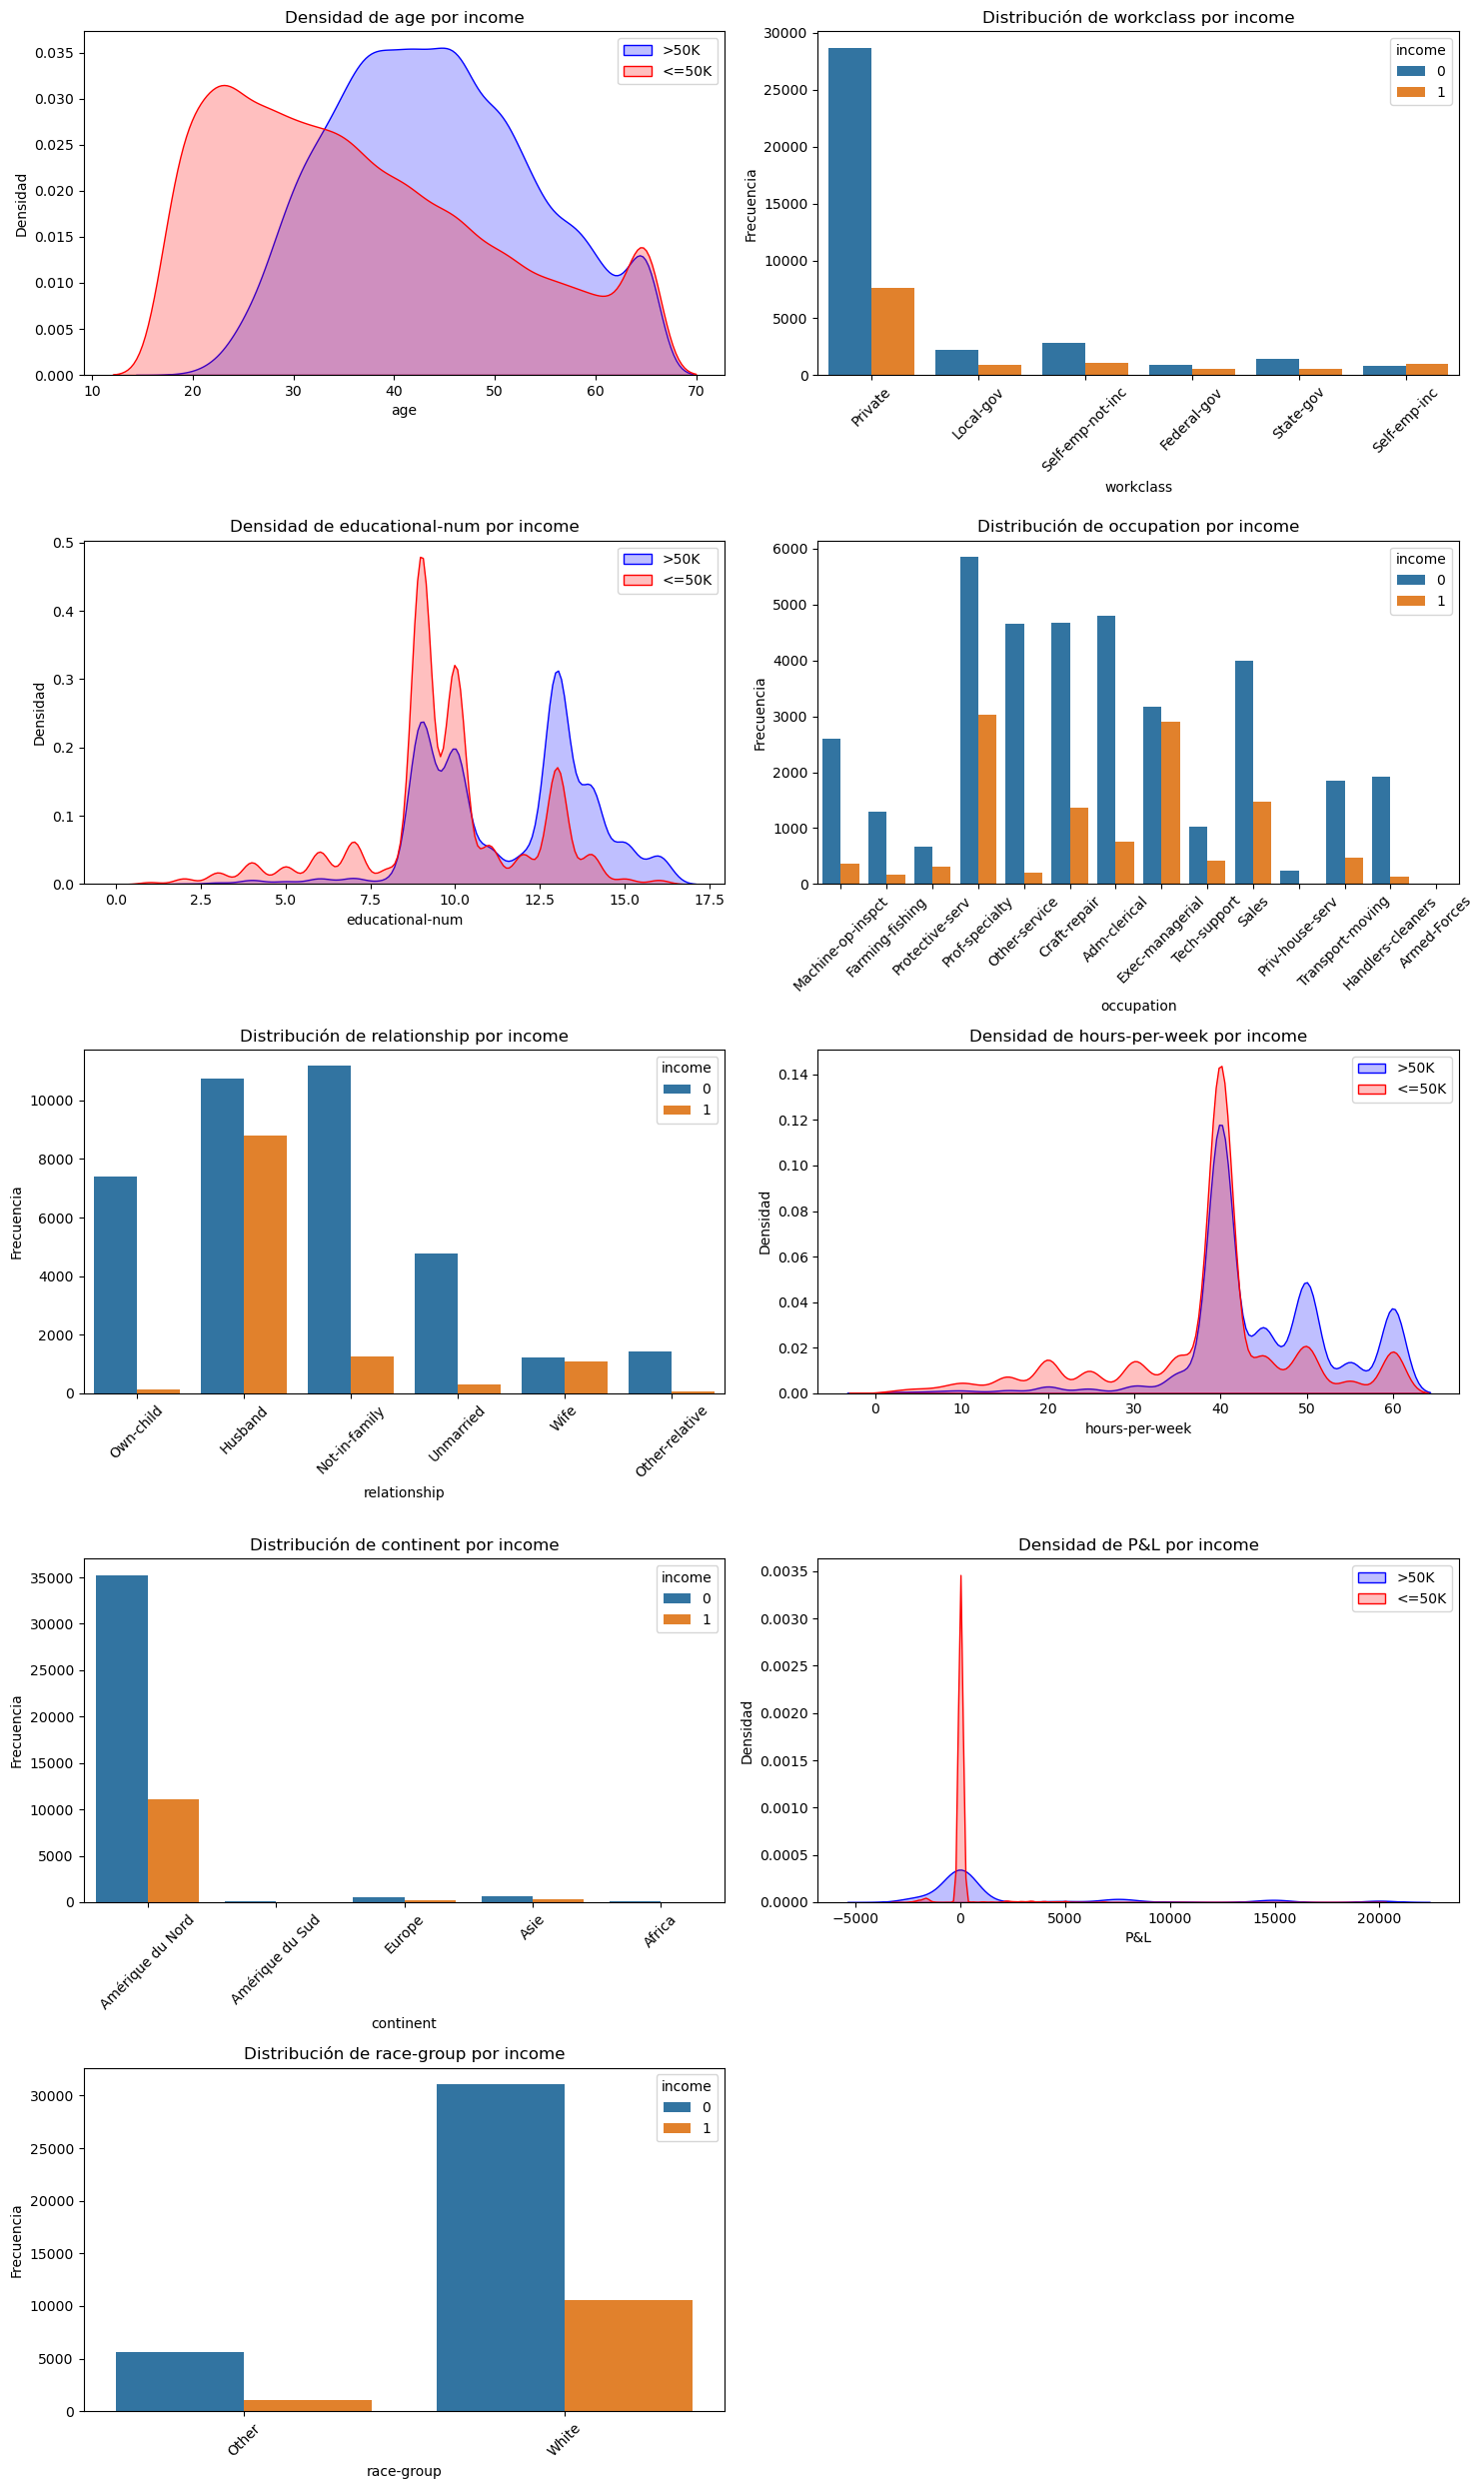

In [221]:
X = df_cleaned.drop(columns=['income'])
y = df_cleaned['income'] 


fig, axs = plt.subplots(nrows=(len(X.columns) + 1) // 2, ncols=2, figsize=(15, 5 * ((len(X.columns) + 1) // 2)))

for i, column in enumerate(X.columns):
    row = i // 2
    col = i % 2
    if X[column].dtype == 'object':
        sns.countplot(data=df_cleaned, x=column, hue='income', ax=axs[row, col])
        axs[row, col].set_title(f'Distribución de {column} por income')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Frecuencia')
        axs[row, col].tick_params(axis='x', rotation=45)
        axs[row, col].legend(title='income')
    elif X[column].dtype in ['int64', 'float64']:
        sns.kdeplot(data=df_cleaned[df_cleaned['income'] == 1], x=column, label='>50K', fill=True, ax=axs[row, col], color='blue')
        sns.kdeplot(data=df_cleaned[df_cleaned['income'] == 0], x=column, label='<=50K', fill=True, ax=axs[row, col], color='red')
        axs[row, col].set_title(f'Densidad de {column} por income')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Densidad')
        axs[row, col].legend()


for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

# Conclusion

- Se puede ver que tenemos datos faltantes y que hay que limpiarlo (caso de los "?")
- Tenemos que tomar en cuenta que es un dataset de Estados Unidos y que el mundo laboral es diferente del nuestro y asi tenemos valores extranas con la edad o el numero de horas trabajadas.
- Con Capital-gain y Capital-loss se puede ver que la moyoria de la gente no inverten en el mercado pero hay algunas personas que ganan mas de 50K que inverten mucho. Hemos creado una variable P&L (profit and loss) para juntar las dos columnas.
- Tenemos variables categorias con redundancias asi hemos eliminido alguna para no tener problema de multicolinealidad. 
- visualmente, las variables age, hour-per-week y educational-num parecen aportar mucha informacion a nuestra target Income.
- Con las variables catgoricas, una pareja tiene mas suerte de tener un sueldo de mas de 50K asi la variable relationship aporta informacion.
- No tenemos un sesgo con la raza y el genero
- Cosa interesente es la correlacion entre una persona qui tiene una gran apetencia con la inversion y un sueldo importante.

- Edad : he mos visto que cuanto mayor mas una persona tiene probabilidad de tener mas de 50K
- Educational-num : hemos eliminado educational para no tener redundancia. Hemos visto que salario esta correlado al pretigio.
- Relationship : hemos decidido de guardar relationship y eliminar marrital-status para no tener redundancia. Una pareja tiene mas probabilidad de tener un sueldo de mas de 50K
- Gender y Race : no hay parece haber tan sesgos en nuetro dataset aunque esta debalanceado. No aportan mucho informacion pero se podra guardarlos en nuestro model_selection.
- Continent : misma cosa con el continente porque tenemos una surrepresentatividad de la gente de origen de america de norte asi no es tan interesente guardarla.
-P&L : la variable P&L es muy interesente y se puede ver que las personas con un P&L de zero son los que no tienen un sueldo mayor a 50K. Las personas que tienen un sueldo de mas de 50K parecen ser los que tienen una apetencia a invertir. Son tambien personas que no le duele mucho perder dinero (P&L negativo pero mas de 50)
- Hours-per-week : hay una correlacion positiva entre en nombre de horas trabajadas y el nivel de sueldo pero no tan alta. 

